# Read the data and clean:

* Summery of what I did:
  1. Count the unique groups based on TTT and LOS to validate the data.
  2. Cut the dataframe to all index groups 1-50 and TTT is 1-20.

In [502]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_20_06.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_25_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_05_07.csv")

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)
df = df1.copy()

In [503]:
df = df.drop("Snapshot", axis=1)

In [504]:
df.columns

Index(['start_date', 'end_date', 'name', 'TTT', 'LOS', 'score', 'reviews',
       'price_per_night', 'original_price', 'discount_perc',
       'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
       'Index', 'star_rating', 'location_rating', 'neighborhood',
       'km_from_center', 'neighborhood_category', 'full_price'],
      dtype='object')

In [505]:
df = df.sort_values(by=["TTT", "LOS", "Index"])

In [483]:
unique_groups_count = df.groupby(['TTT', 'LOS']).ngroups

In [484]:
unique_groups_count

150

In [506]:
# Filter the dataset to include TTT between 1 and 20 and Index between 1 and 50
df = df[(df['TTT'] >= 1) & (df['TTT'] <= 20) & (df['Index'] >= 1) & (df['Index'] <= 50)]
model_trainning_data = df[(df['TTT'] >= 1) & (df['TTT'] <= 20) & (df['Index'] >= 1) & (df['Index'] <= 50)]

In [507]:
df.groupby(['TTT', 'LOS']).ngroups

100

# Preprocess Data

* summery of what I did:
  1. Split the dataframe to 2 parts:
     * Even TTT - for the train
     * Odd TTT - for the test

In [487]:
df["Index"].max()

50

In [488]:
model_trainning_data["Index"].max()

50

In [508]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into training and test sets based on TTT values
even_ttt = model_trainning_data[model_trainning_data['TTT'] % 2 == 0]
odd_ttt = model_trainning_data[model_trainning_data['TTT'] % 2 != 0]

print(f"sum of EVEN TTT unique groups: {even_ttt.groupby(['TTT', 'LOS']).ngroups}")
print(f"sum of ODD TTT unique groups: {odd_ttt.groupby(['TTT', 'LOS']).ngroups}")

# Select n unique groups for training and testing
train_groups = even_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=50)
train_data = pd.merge(even_ttt, train_groups, on=['TTT', 'LOS'])

test_groups = odd_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=20)
test_data = pd.merge(odd_ttt, test_groups, on=['TTT', 'LOS'])

sum of EVEN TTT unique groups: 50
sum of ODD TTT unique groups: 50


# Model Training

* Summery of what I did:

  1. I choose the features that I want to based on in my model: 'full_price', 'km_from_center', 'star_rating', 'reviews', 'score','discount_perc', 'location_rating'.
  2. Run desicion tree model while the train_x value is the data from the features I coohse before, and train_y is the boolian value of the diff between each 2 rows.

In [490]:
test_data.columns

Index([           'start_date',              'end_date',
                        'name',                   'TTT',
                         'LOS',                 'score',
                     'reviews',       'price_per_night',
              'original_price',         'discount_perc',
           'Free_cancellation',            'No_payment',
                   'Breakfast',         'Option Member',
                       'Index',           'star_rating',
             'location_rating',          'neighborhood',
              'km_from_center', 'neighborhood_category',
                  'full_price',                       0],
      dtype='object')

In [509]:
# Define features and target for the model
features = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']
train_X = train_data[features]
# train_y = (train_data['Index'].diff().shift(-1) < 0).astype(int)

# Adjust the target variable definition to be binary based on ranking comparison
train_y = (train_data['Index'].rank(method='first') % 2 == 0).astype(int)

In [510]:
# Split training data further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [511]:
# Train the Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predict on validation set
y_pred = clf.predict(X_val)

In [494]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.49      0.52       255
           1       0.48      0.52      0.50       227

    accuracy                           0.51       482
   macro avg       0.51      0.51      0.51       482
weighted avg       0.51      0.51      0.51       482

Accuracy Score: 0.508298755186722


# Sorting Function:

* Summery of what I did:
  1. compare_hotels():
     * Receives 2 hotels (pairs), and returns the predection based on the desicion tree model that I created before and returns 1 or -1.
  2. bubble_sort_hotels():
     * the function receives hotels dataframe and returns the sorted datarframe based on the model.
       

In [499]:
# Function to compare two hotels using the trained model
def compare_hotels(hotel1, hotel2):
    features = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']
    pair = pd.DataFrame([hotel1[features], hotel2[features]])
    prediction = clf.predict(pair)
    return 1 if prediction[0] else -1
    
# Bubble Sort using the model
# def bubble_sort_hotels(hotels):
#     n = len(hotels)
#     for i in range(n):
#         for j in range(0, n-i-1):
#             if compare_hotels(hotels.iloc[j], hotels.iloc[j+1]) == -1:
#                 hotels.iloc[j], hotels.iloc[j+1] = hotels.iloc[j+1], hotels.iloc[j]
#     return hotels


# Efficient sorting using merge sort
def merge_sort_hotels(hotels):
    if len(hotels) > 1:
        mid = len(hotels) // 2
        left_half = hotels.iloc[:mid]
        right_half = hotels.iloc[mid:]

        left_sorted = merge_sort_hotels(left_half)
        right_sorted = merge_sort_hotels(right_half)

        return merge(left_sorted, right_sorted)
    else:
        return hotels

def merge(left, right):
    sorted_hotels = pd.DataFrame(columns=left.columns)
    while len(left) > 0 and len(right) > 0:
        if compare_hotels(left.iloc[0], right.iloc[0]) == -1:
            sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
            left = left.iloc[1:]
        else:
            sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
            right = right.iloc[1:]
    sorted_hotels = pd.concat([sorted_hotels, left])
    sorted_hotels = pd.concat([sorted_hotels, right])
    return sorted_hotels

# Performance Evaluation:
* Summery of what I did:
  1. Shuffel the test data
  2. Sort the shffeled data with the model and bubble sort function.
  3. calculate the diff between the the sorted indexes and the original indexes
  4. calculate the avg and std. 

C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

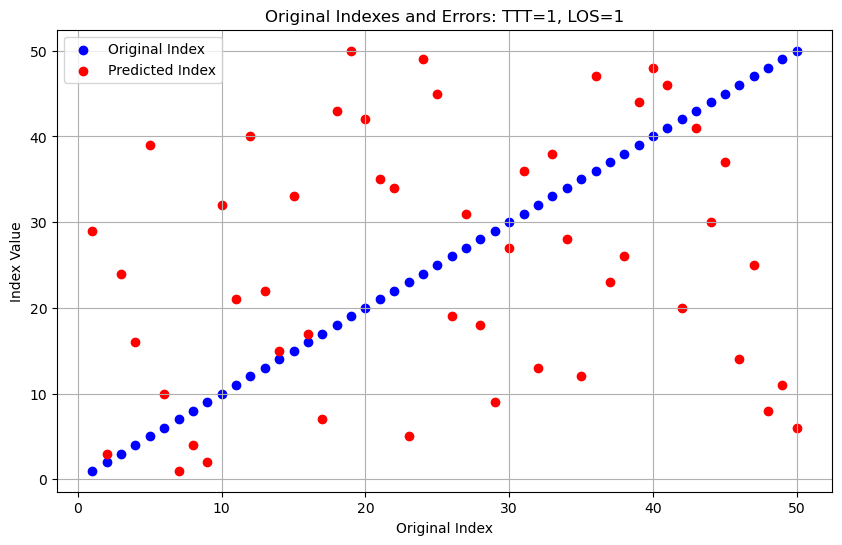

Accuracy rate for group TTT=1, LOS=1: 0.43


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

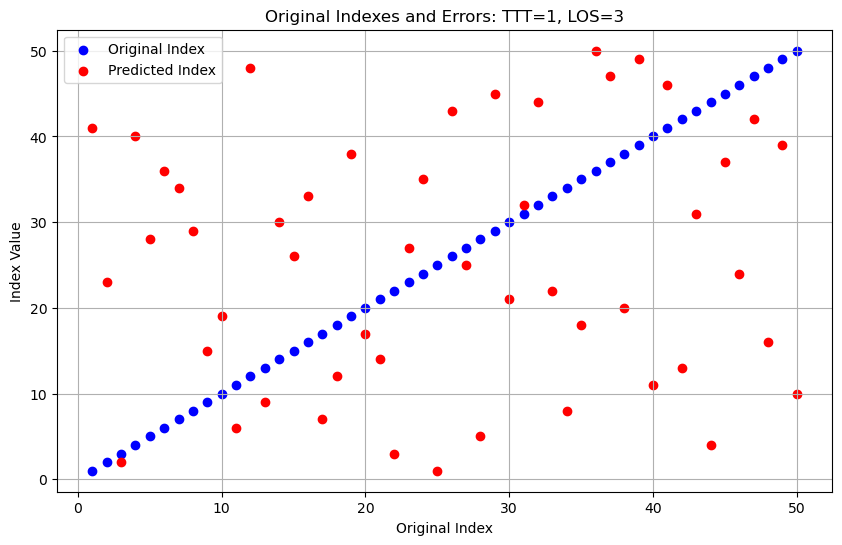

Accuracy rate for group TTT=1, LOS=3: 0.45


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

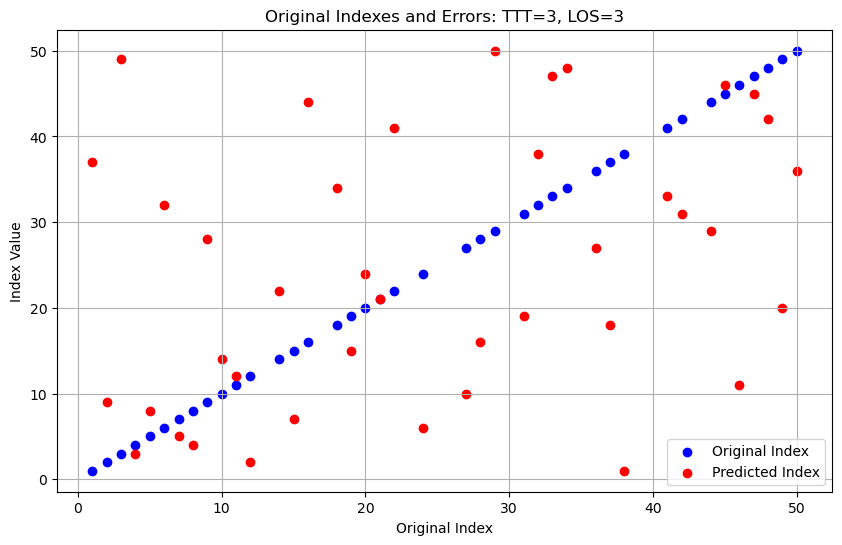

Accuracy rate for group TTT=3, LOS=3: 0.46


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

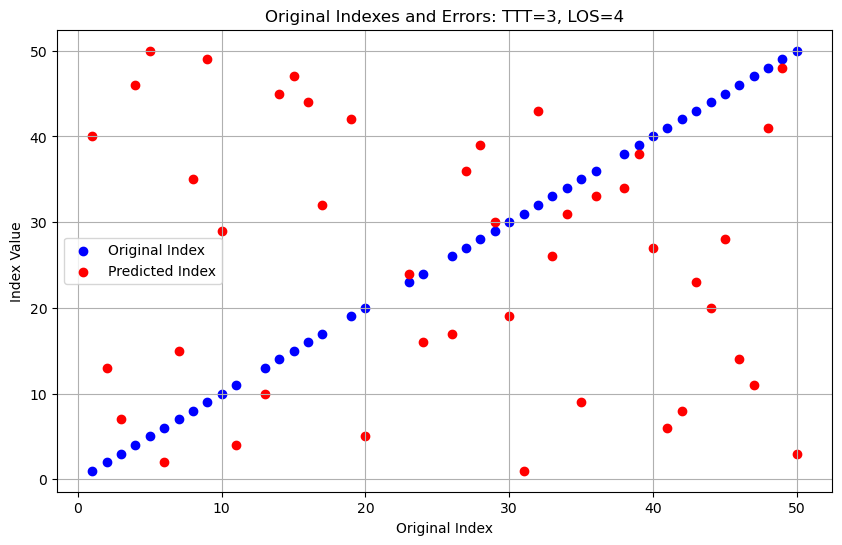

Accuracy rate for group TTT=3, LOS=4: 0.53


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is de

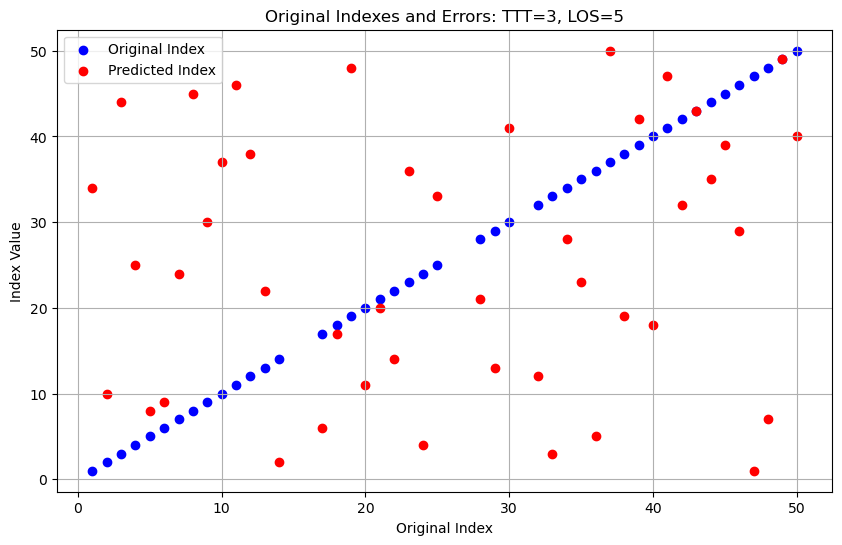

Accuracy rate for group TTT=3, LOS=5: 0.48


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

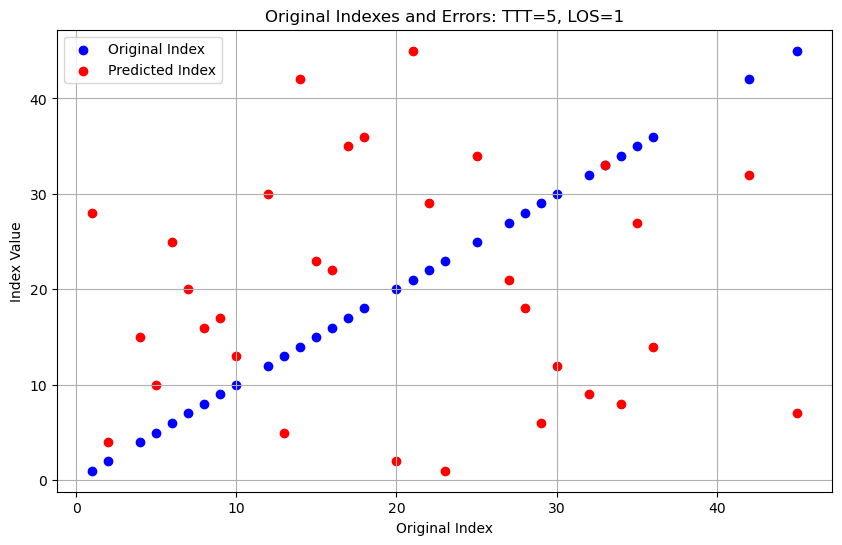

Accuracy rate for group TTT=5, LOS=1: 0.42


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

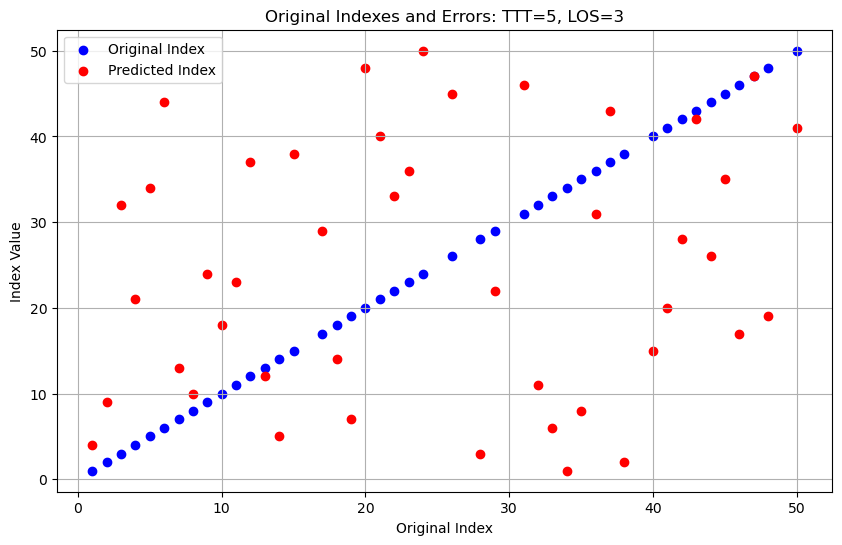

Accuracy rate for group TTT=5, LOS=3: 0.53


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

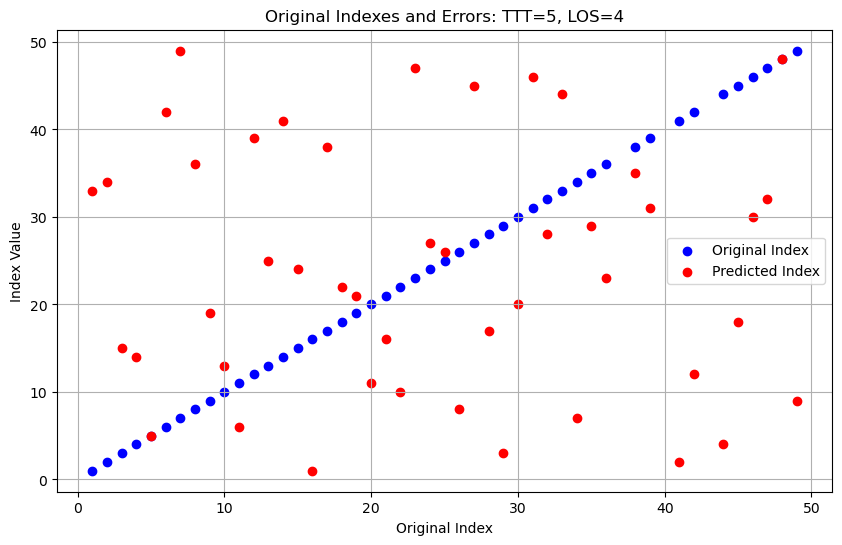

Accuracy rate for group TTT=5, LOS=4: 0.42


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

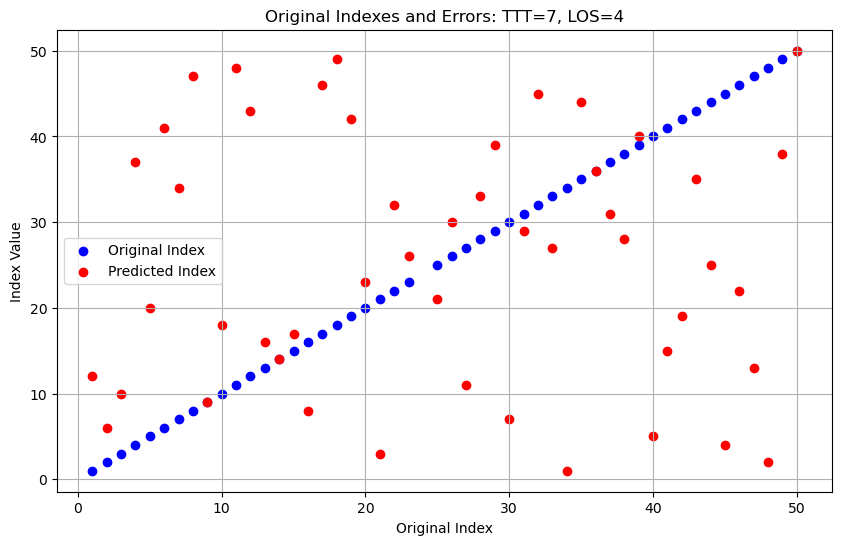

Accuracy rate for group TTT=7, LOS=4: 0.48


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

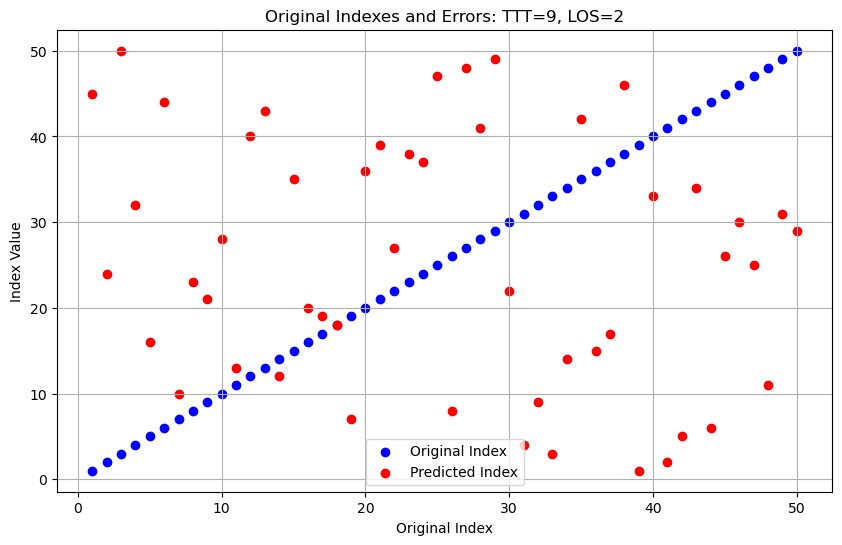

Accuracy rate for group TTT=9, LOS=2: 0.49


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

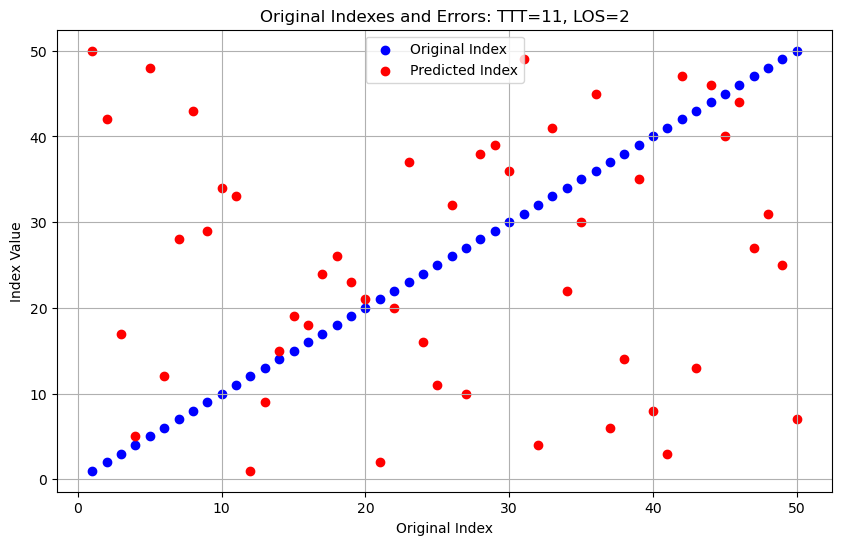

Accuracy rate for group TTT=11, LOS=2: 0.49


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

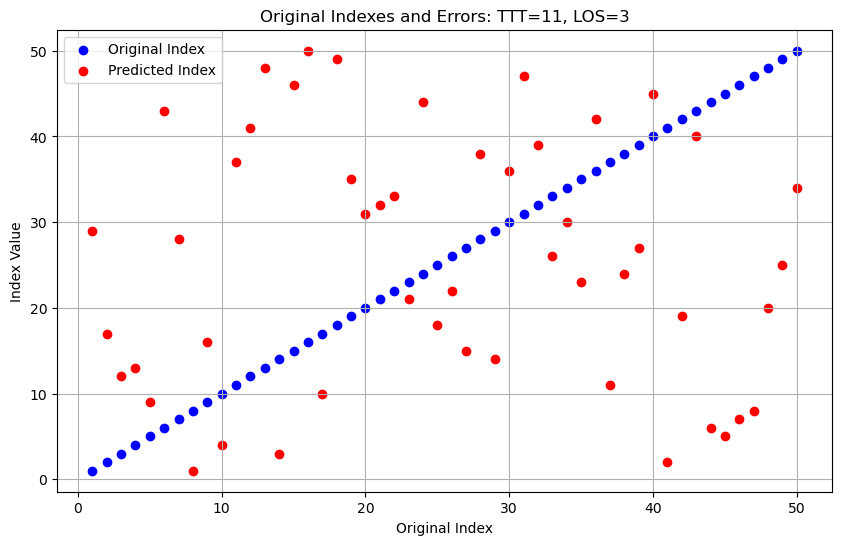

Accuracy rate for group TTT=11, LOS=3: 0.57


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

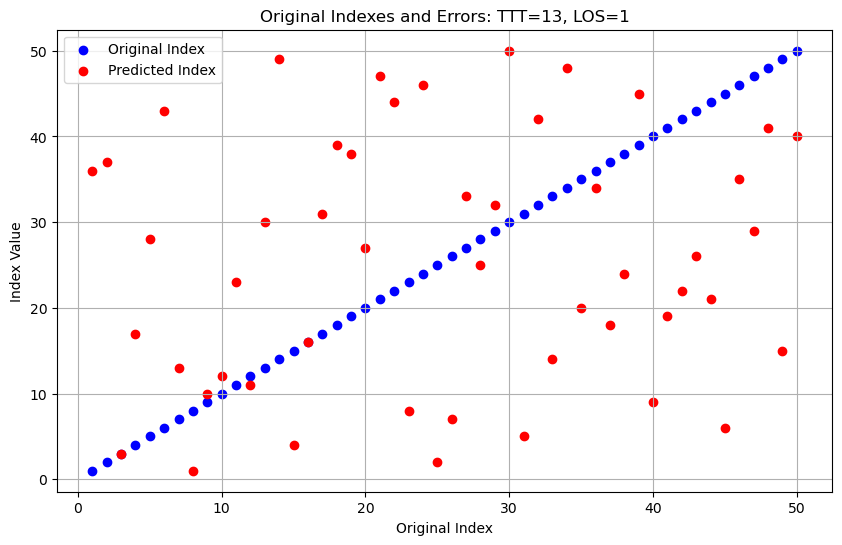

Accuracy rate for group TTT=13, LOS=1: 0.59


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

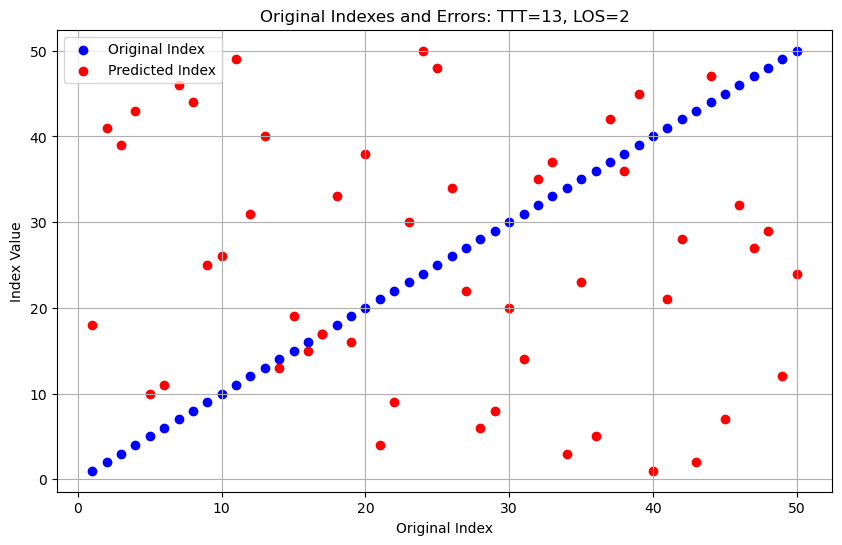

Accuracy rate for group TTT=13, LOS=2: 0.55


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

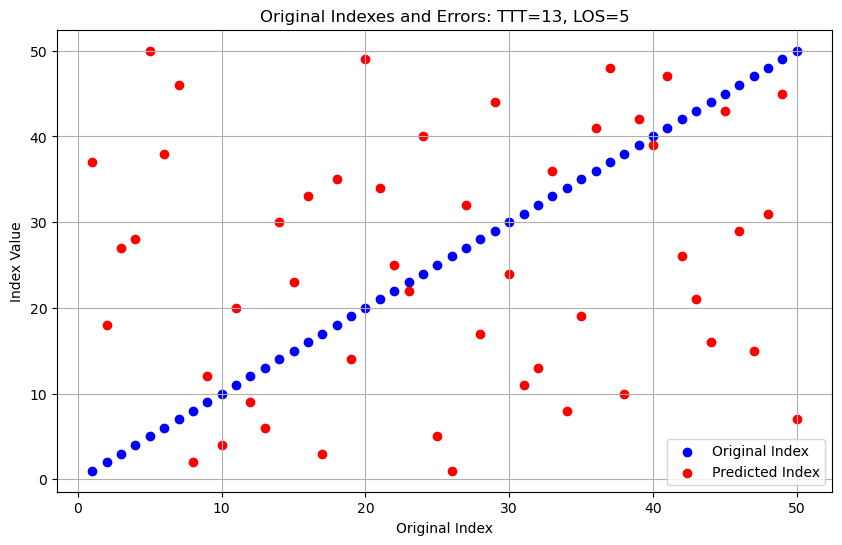

Accuracy rate for group TTT=13, LOS=5: 0.47


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

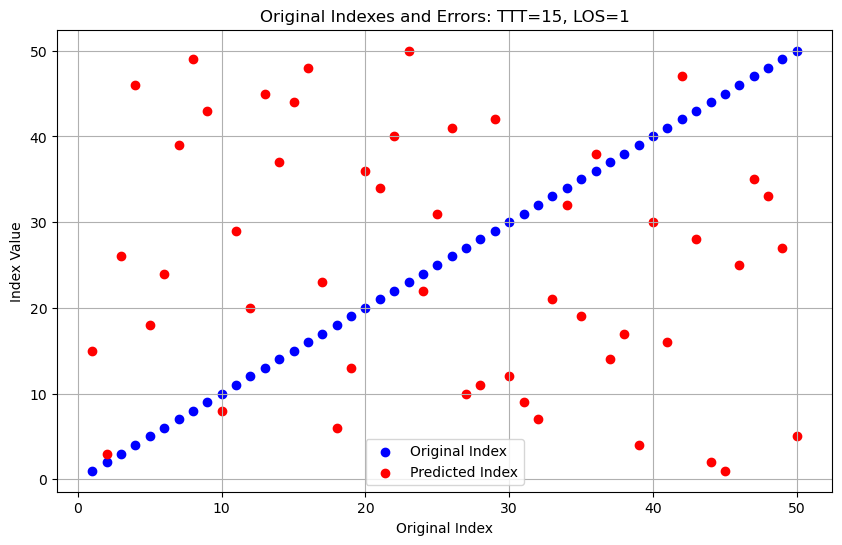

Accuracy rate for group TTT=15, LOS=1: 0.51


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

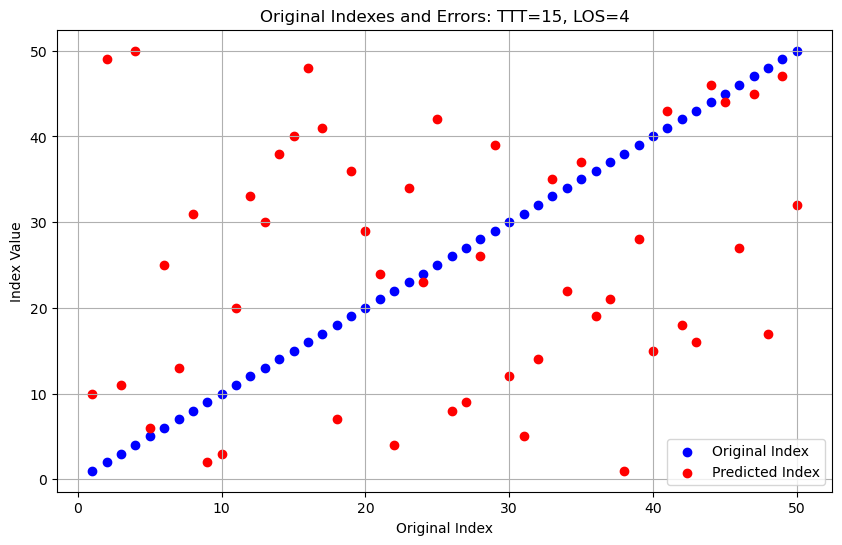

Accuracy rate for group TTT=15, LOS=4: 0.51


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

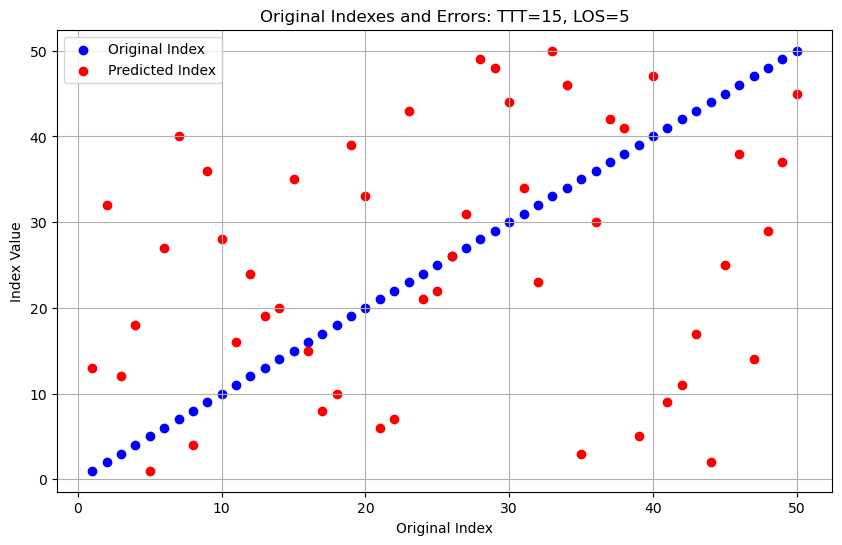

Accuracy rate for group TTT=15, LOS=5: 0.55


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, right.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

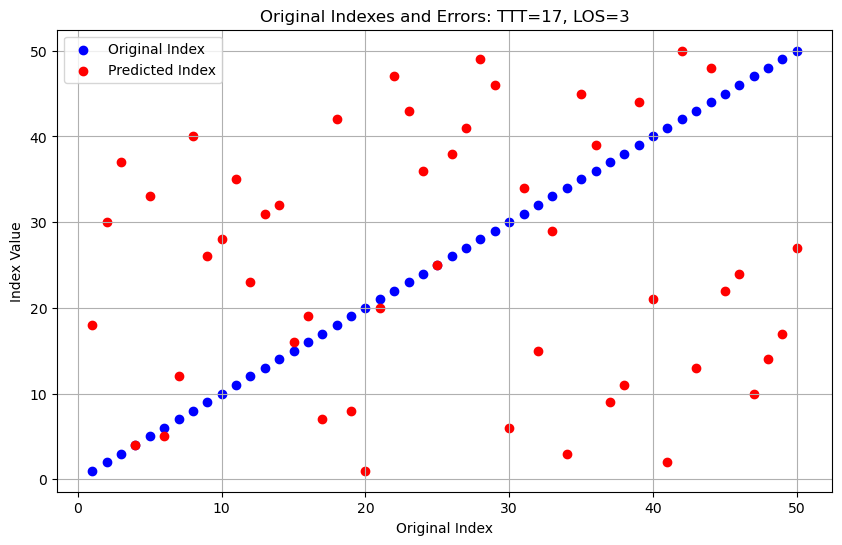

Accuracy rate for group TTT=17, LOS=3: 0.55


C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sorted_hotels = pd.concat([sorted_hotels, left.iloc[[0]]])
C:\Users\User\AppData\Local\Temp\ipykernel_10408\3088578140.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is de

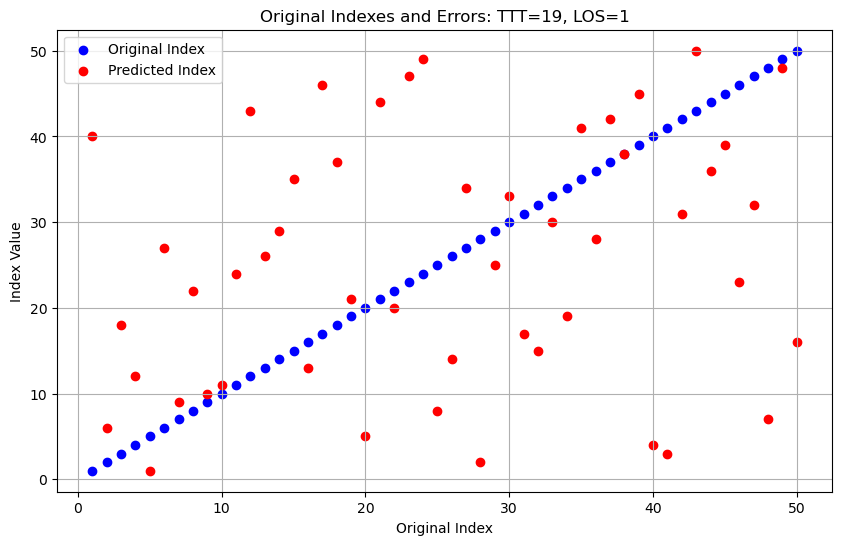

Accuracy rate for group TTT=19, LOS=1: 0.51
Average Error: 19225.50, Standard Deviation of Error: 3913.44


In [500]:
errors = []
all_original_indices = []
all_sorted_indices = []
accuracy_rates = []


for name, group in test_data.groupby(['TTT', 'LOS']):
    original_indices = group['Index'].values
    shuffled_group = group.sample(frac=1).reset_index(drop=True)
    sorted_group = merge_sort_hotels(shuffled_group)
    sorted_indices = sorted_group['Index'].values
    error = np.sum((sorted_indices - original_indices)**2)
    errors.append(error)

    # Calculate accuracy
    correct_predictions = sum((sorted_indices[i] < sorted_indices[i+1]) == (original_indices[i] < original_indices[i+1])
                              for i in range(len(sorted_indices) - 1))
    accuracy_rate = correct_predictions / (len(sorted_indices) - 1)
    accuracy_rates.append(accuracy_rate)

    # Plot the original indexes as blue points and the errors as red points for each original index
    plt.figure(figsize=(10, 6))
    plt.scatter(original_indices, original_indices, color='blue', label='Original Index')
    plt.scatter(original_indices, sorted_indices, color='red', label='Predicted Index')
    plt.title(f'Original Indexes and Errors: TTT={group["TTT"].values[0]}, LOS={group["LOS"].values[0]}')
    plt.xlabel('Original Index')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Accuracy rate for group TTT={group['TTT'].values[0]}, LOS={group['LOS'].values[0]}: {accuracy_rate:.2f}")

    all_original_indices.extend(original_indices)
    all_sorted_indices.extend(sorted_indices)

# Calculate the average and standard deviation of errors
avg_error = np.mean(errors)
std_error = np.std(errors)
print(f"Average Error: {avg_error:.2f}, Standard Deviation of Error: {std_error:.2f}")

In [432]:
# Display the results
print(f'Average Error: {avg_error}')
print(f'Standard Deviation of Errors: {std_error}')

Average Error: 20496.4
Standard Deviation of Errors: 3714.990530270568


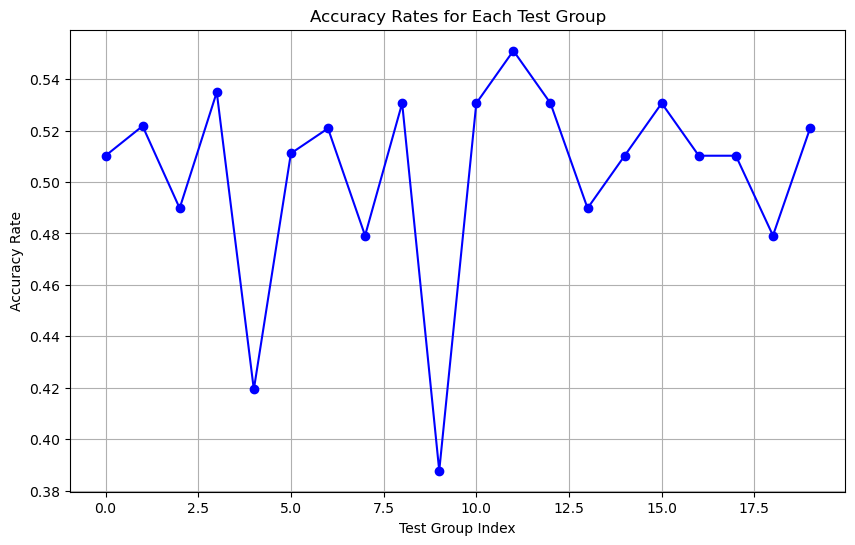

In [433]:
# Plot the overall accuracy rates
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_rates)), accuracy_rates, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Rates for Each Test Group')
plt.xlabel('Test Group Index')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


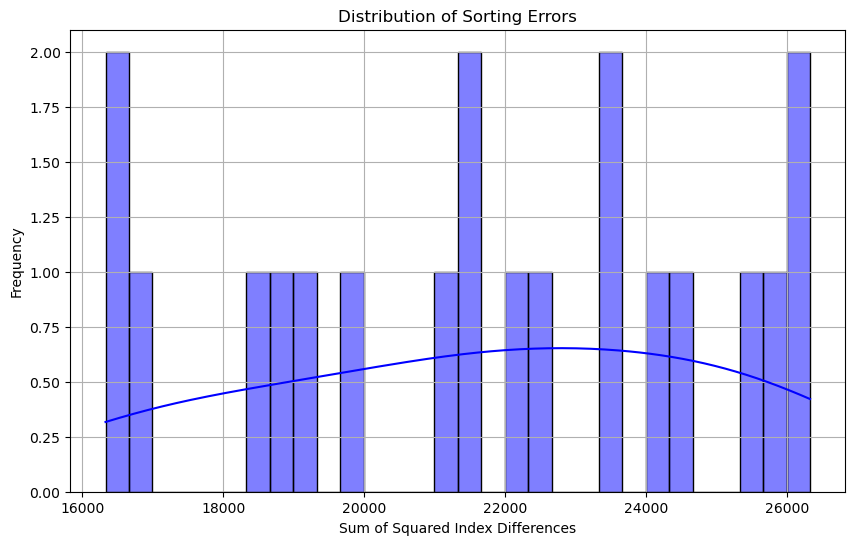

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'errors' list is already calculated as before

# Plot the errors using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='blue')
plt.title('Distribution of Sorting Errors')
plt.xlabel('Sum of Squared Index Differences')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

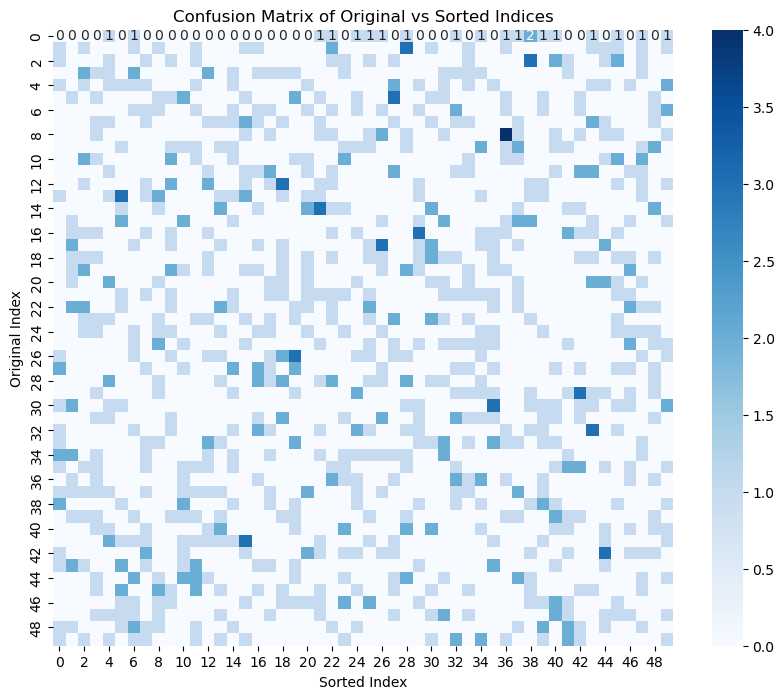

In [405]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_original_indices, all_sorted_indices)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Original vs Sorted Indices')
plt.xlabel('Sorted Index')
plt.ylabel('Original Index')
plt.show()

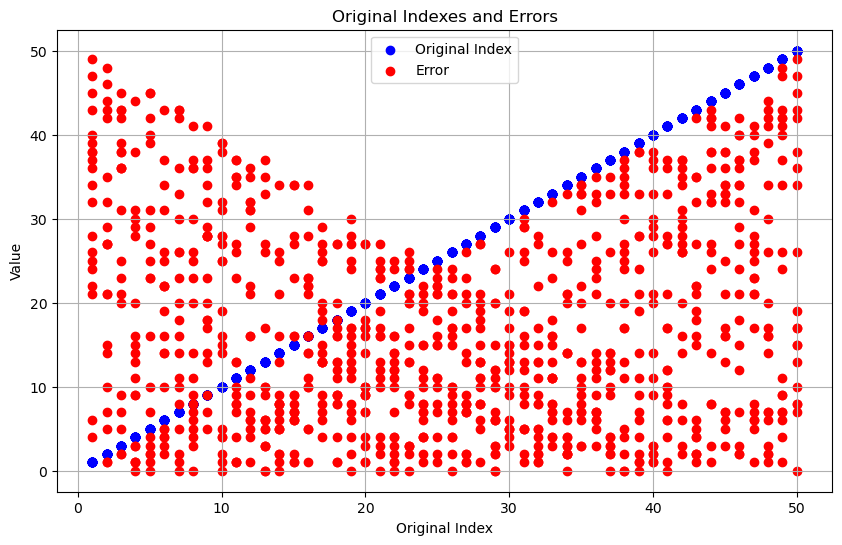

In [406]:
# Plot the original indexes as blue points and the errors as red points for each original index
plt.figure(figsize=(10, 6))
plt.scatter(all_original_indices, all_original_indices, color='blue', label='Original Index')
plt.scatter(all_original_indices, np.abs(np.array(all_original_indices) - np.array(all_sorted_indices)), color='red', label='Error')
plt.title('Original Indexes and Errors')
plt.xlabel('Original Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# TEST

In [515]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Dummy dataset for demonstration (Replace this with your actual dataset)
data = {
    'TTT': np.random.randint(1, 21, 1000),
    'Index': np.random.randint(1, 51, 1000),
    'full_price': np.random.random(1000),
    'km_from_center': np.random.random(1000),
    'star_rating': np.random.random(1000),
    'reviews': np.random.random(1000),
    'score': np.random.random(1000),
    'discount_perc': np.random.random(1000),
    'location_rating': np.random.random(1000)
}

df = df1.copy()

# Filter the dataset
df = df[(df['TTT'] >= 1) & (df['TTT'] <= 20) & (df['Index'] >= 1) & (df['Index'] <= 50)]
model_training_data = df[(df['TTT'] >= 1) & (df['TTT'] <= 20) & (df['Index'] >= 1) & (df['Index'] <= 50)]

# Split data into training and test sets based on TTT values
even_ttt = model_training_data[model_training_data['TTT'] % 2 == 0]
odd_ttt = model_training_data[model_training_data['TTT'] % 2 != 0]

print(f"sum of EVEN TTT unique groups: {even_ttt.groupby(['TTT', 'LOS']).ngroups}")
print(f"sum of ODD TTT unique groups: {odd_ttt.groupby(['TTT', 'LOS']).ngroups}")

# Select n unique groups for training
train_groups = even_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=50)
train_data = pd.merge(even_ttt, train_groups, on=['TTT', 'LOS'])

# Select n unique groups for testing
test_groups = odd_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=20)
test_data = pd.merge(odd_ttt, test_groups, on=['TTT', 'LOS'])

# Function to create features for a pair of hotels
def create_pair_features(hotel1, hotel2):
    features = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']
    pair_features = []
    for feature in features:
        pair_features.append(hotel1[feature] - hotel2[feature])
    return pair_features

# Function to generate random pairs and create a dataset
def generate_pair_dataset(df):
    np.random.seed(42)  # For reproducibility
    num_pairs = 10000  # Number of pairs to generate
    indices = np.random.choice(df.index, size=(num_pairs, 2), replace=True)
    
    data = []
    labels = []
    index_pairs = []
    
    for idx1, idx2 in indices:
        if idx1 == idx2:
            continue
        hotel1 = df.loc[idx1]
        hotel2 = df.loc[idx2]
        
        pair_features = create_pair_features(hotel1, hotel2)
        label = 1 if hotel1['Index'] > hotel2['Index'] else 0
        
        data.append(pair_features)
        labels.append(label)
        index_pairs.append((hotel1['Index'], hotel2['Index']))
    
    return pd.DataFrame(data, columns=[f'{f}_diff' for f in features]), np.array(labels), index_pairs

# Generate the dataset
X, y, index_pairs = generate_pair_dataset(train_data)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val, index_pairs_train, index_pairs_val = train_test_split(X, y, index_pairs, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_pred = clf.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy Score:", accuracy)

# Print pairs and what the model predicts for each pair
print("\nPair (Index1, Index2) | Predicted Order")
for (index1, index2), predicted_value in zip(index_pairs_val, y_pred):
    predicted_order = f"{index2} -> {index1}" if predicted_value == 1 else f"{index1} -> {index2}"
    print(f"({index1}, {index2})           | {predicted_order}")

# Optionally print true values for comparison
print("\nPair (Index1, Index2) | True Order      | Predicted Order")
for (index1, index2), true_value, predicted_value in zip(index_pairs_val, y_val, y_pred):
    true_order = f"{index2} -> {index1}" if true_value == 1 else f"{index1} -> {index2}"
    predicted_order = f"{index2} -> {index1}" if predicted_value == 1 else f"{index1} -> {index2}"
    print(f"({index1}, {index2})           | {true_order} | {predicted_order}")


sum of EVEN TTT unique groups: 50
sum of ODD TTT unique groups: 50
Accuracy Score: 0.6495

Pair (Index1, Index2) | Predicted Order
(10, 12)           | 10 -> 12
(17, 22)           | 17 -> 22
(39, 43)           | 39 -> 43
(24, 35)           | 35 -> 24
(8, 5)           | 8 -> 5
(26, 4)           | 26 -> 4
(8, 28)           | 28 -> 8
(1, 4)           | 1 -> 4
(15, 9)           | 9 -> 15
(37, 9)           | 9 -> 37
(29, 48)           | 29 -> 48
(31, 5)           | 5 -> 31
(45, 39)           | 39 -> 45
(15, 9)           | 9 -> 15
(18, 43)           | 43 -> 18
(29, 5)           | 29 -> 5
(2, 38)           | 2 -> 38
(5, 35)           | 35 -> 5
(8, 3)           | 8 -> 3
(14, 14)           | 14 -> 14
(13, 25)           | 13 -> 25
(25, 2)           | 2 -> 25
(29, 44)           | 44 -> 29
(25, 16)           | 25 -> 16
(17, 39)           | 17 -> 39
(12, 17)           | 17 -> 12
(29, 27)           | 27 -> 29
(14, 23)           | 23 -> 14
(50, 8)           | 50 -> 8
(36, 25)           | 36 -> 25
(41

# Repeat on the proccess testing decision tree model on the pages data

In [517]:
import warnings
warnings.filterwarnings('ignore')

sum of EVEN TTT unique groups: 50
sum of ODD TTT unique groups: 50
Accuracy Score: 0.6495


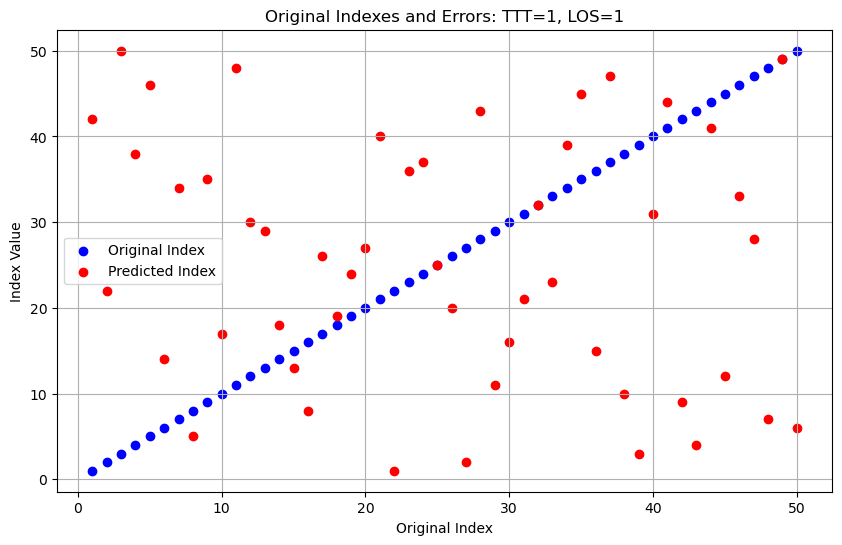

Accuracy rate for group TTT=1, LOS=1: 0.47


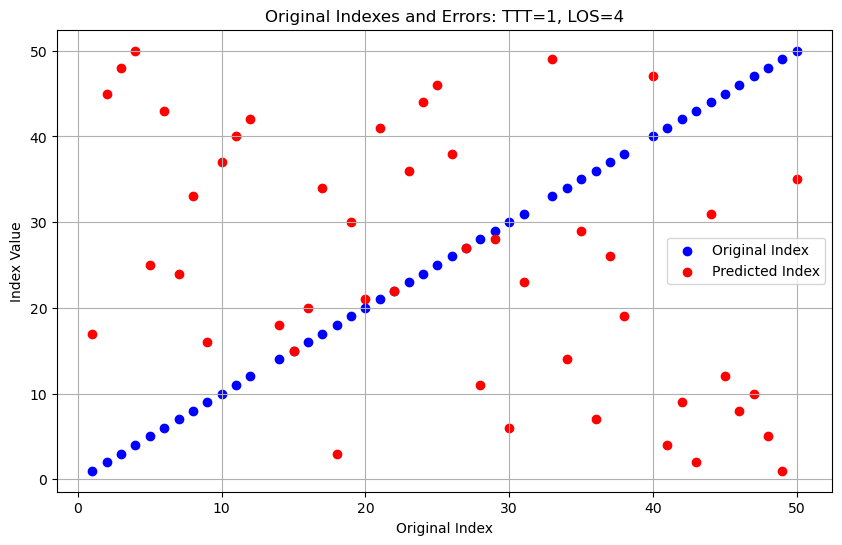

Accuracy rate for group TTT=1, LOS=4: 0.54


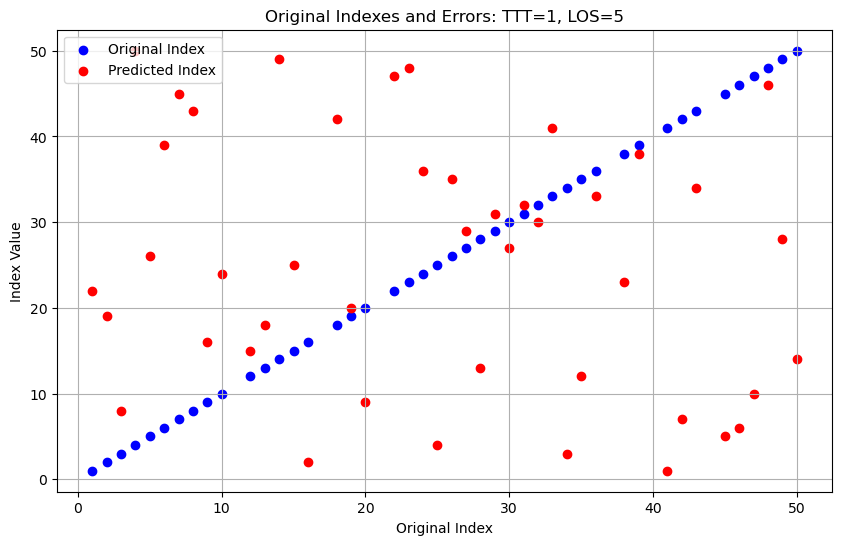

Accuracy rate for group TTT=1, LOS=5: 0.49


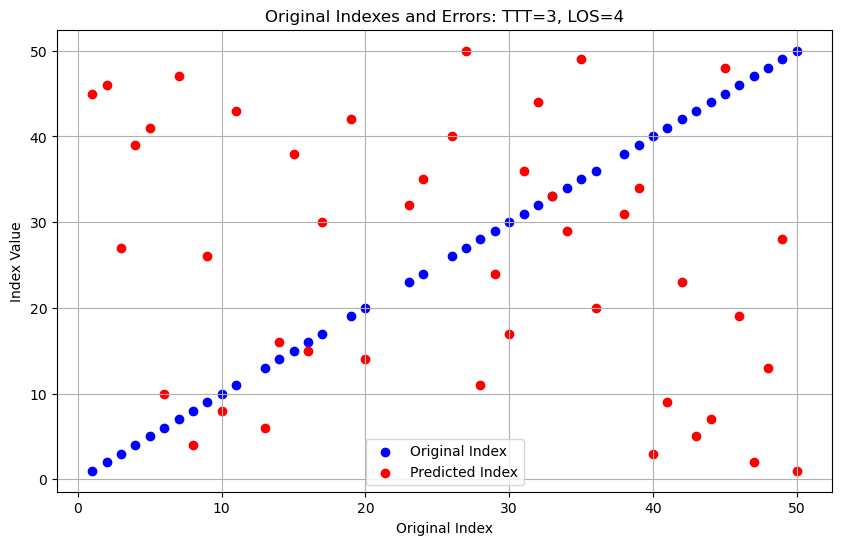

Accuracy rate for group TTT=3, LOS=4: 0.60


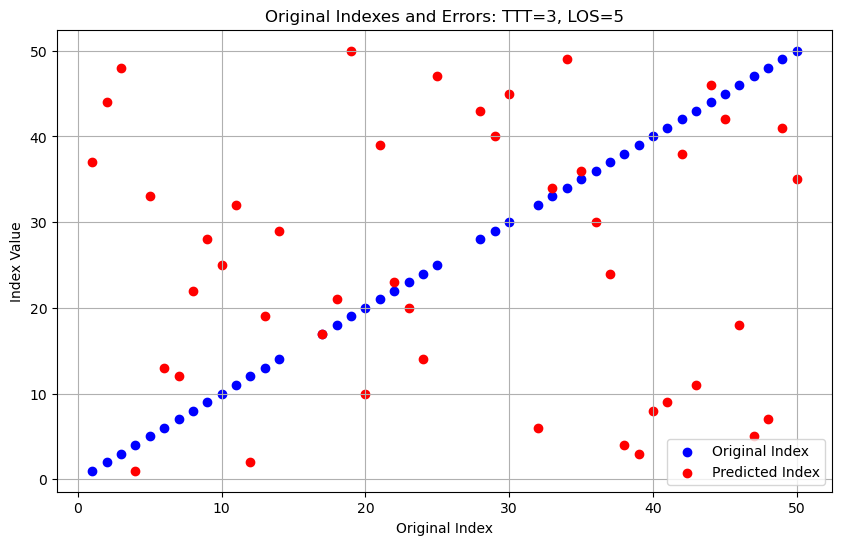

Accuracy rate for group TTT=3, LOS=5: 0.48


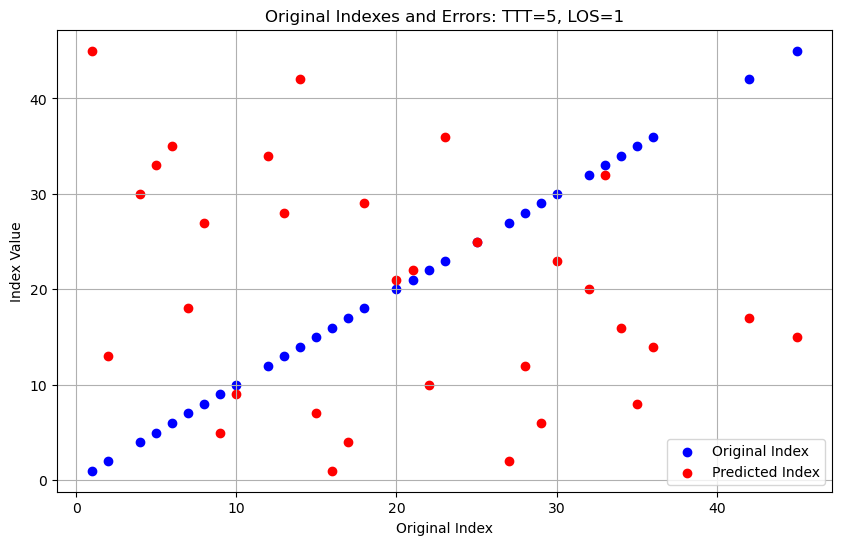

Accuracy rate for group TTT=5, LOS=1: 0.52


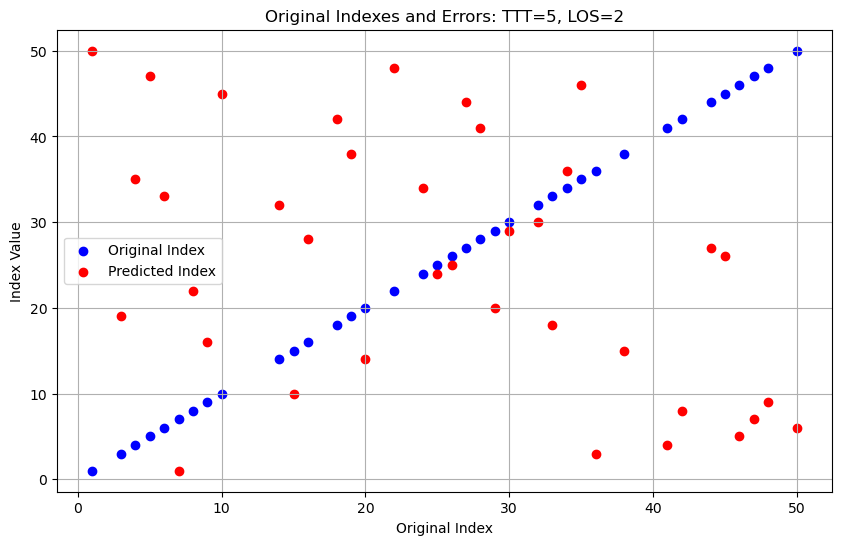

Accuracy rate for group TTT=5, LOS=2: 0.50


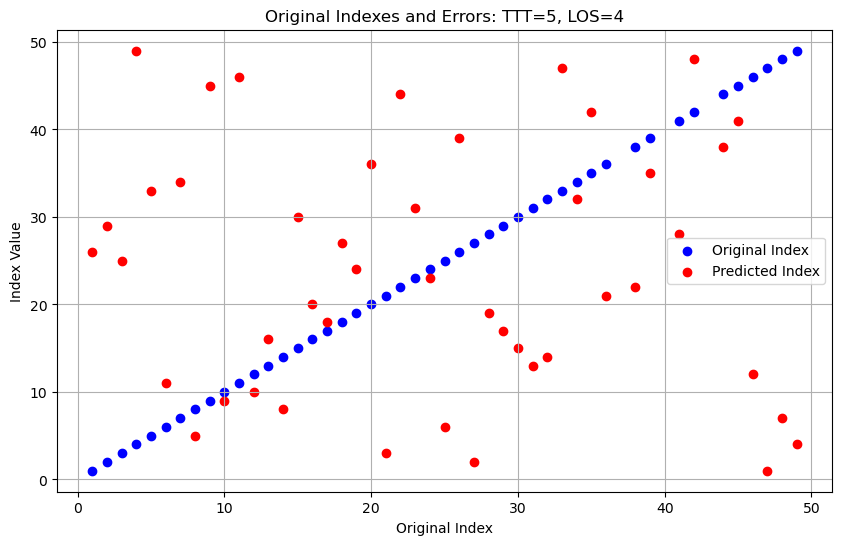

Accuracy rate for group TTT=5, LOS=4: 0.44


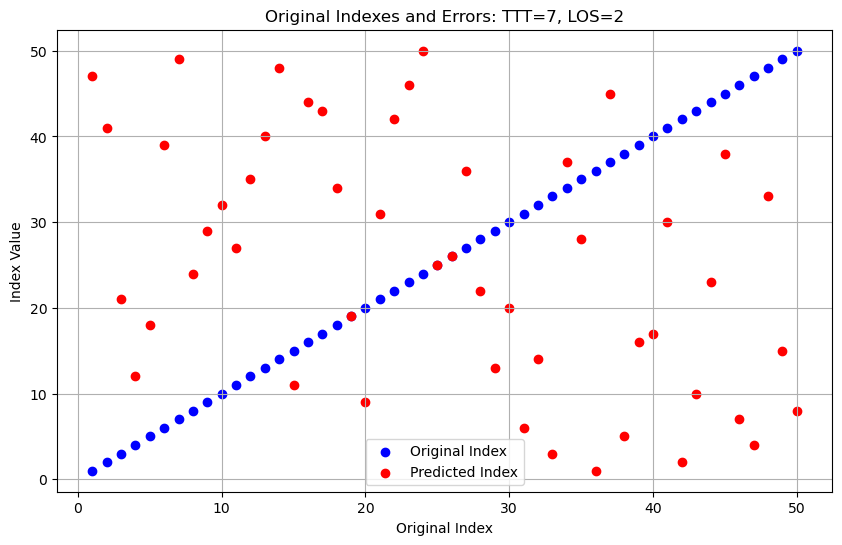

Accuracy rate for group TTT=7, LOS=2: 0.53


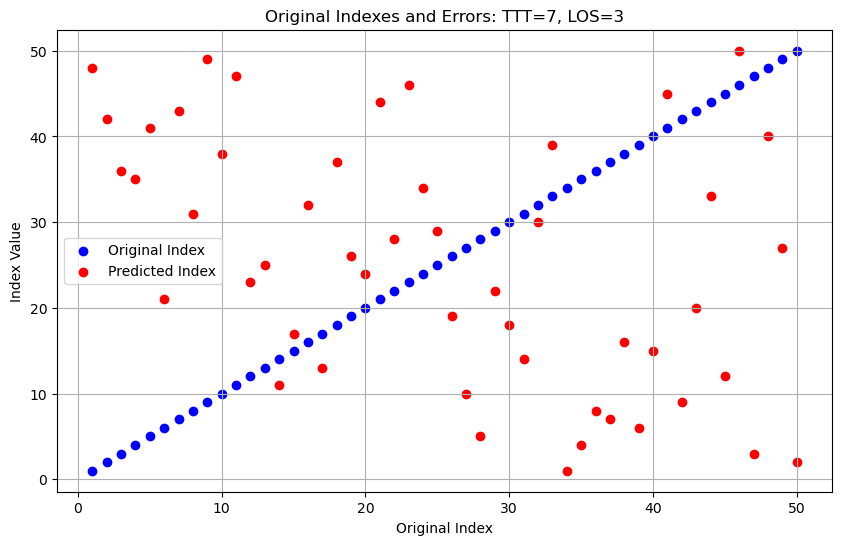

Accuracy rate for group TTT=7, LOS=3: 0.45


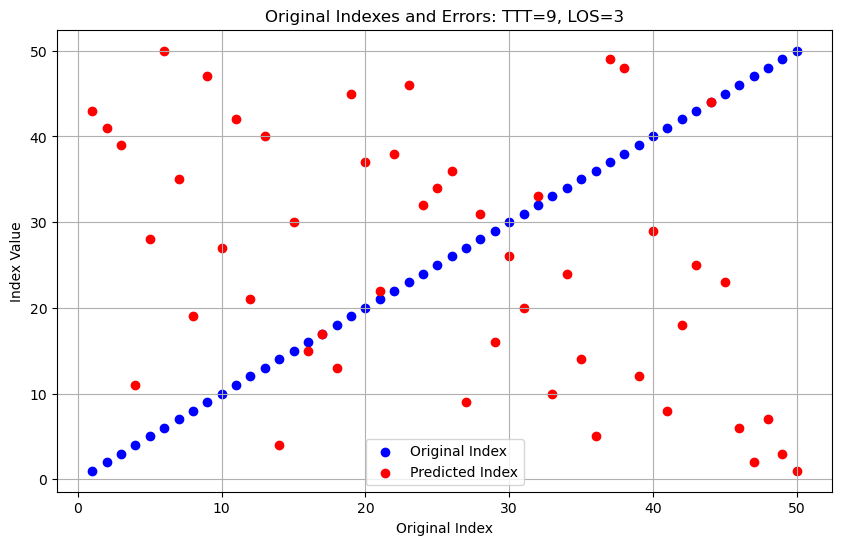

Accuracy rate for group TTT=9, LOS=3: 0.45


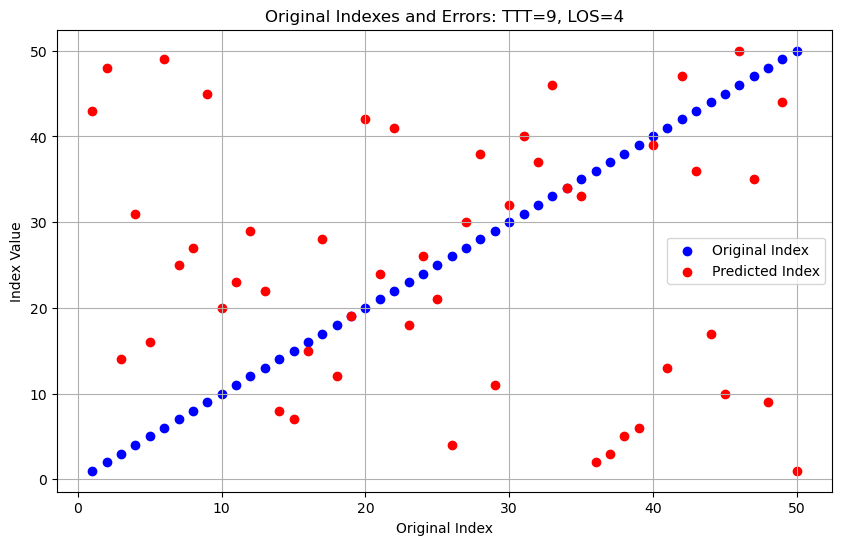

Accuracy rate for group TTT=9, LOS=4: 0.51


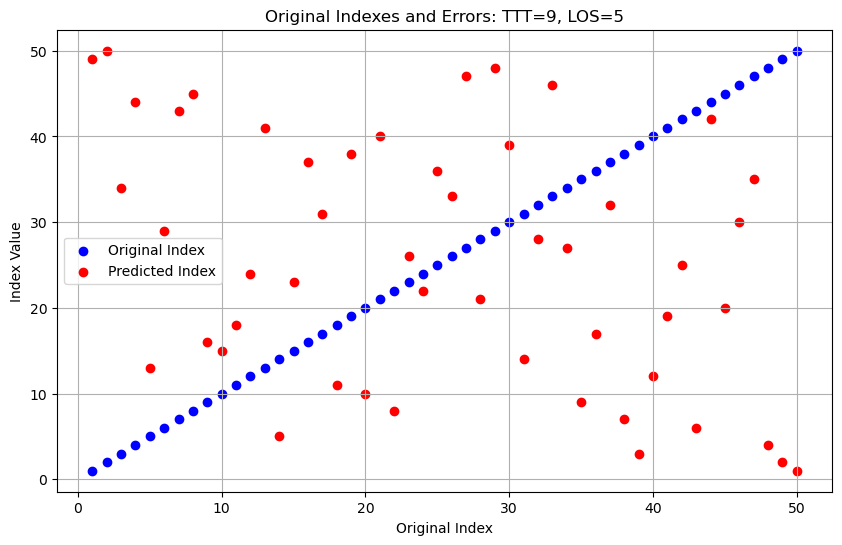

Accuracy rate for group TTT=9, LOS=5: 0.53


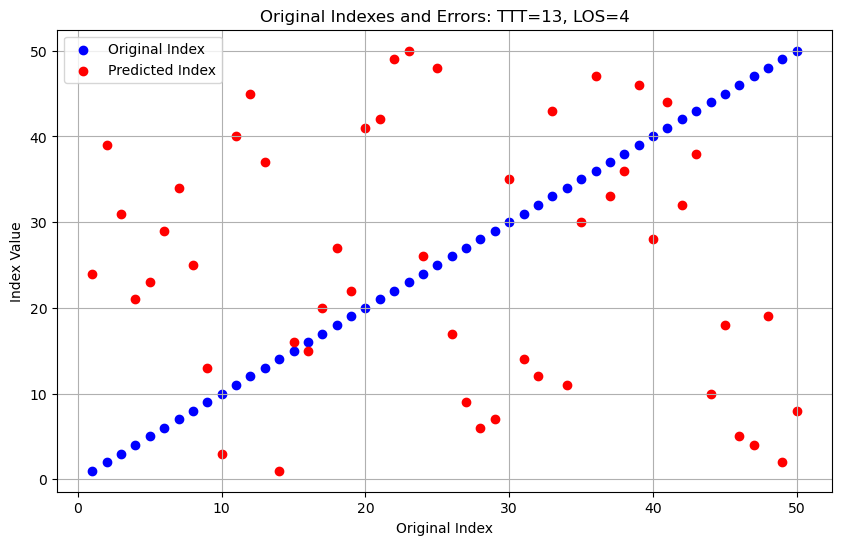

Accuracy rate for group TTT=13, LOS=4: 0.53


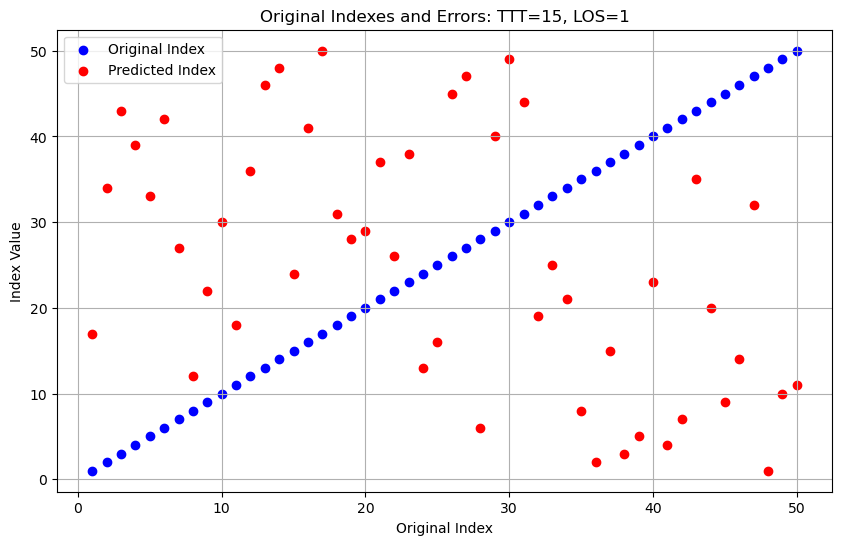

Accuracy rate for group TTT=15, LOS=1: 0.57


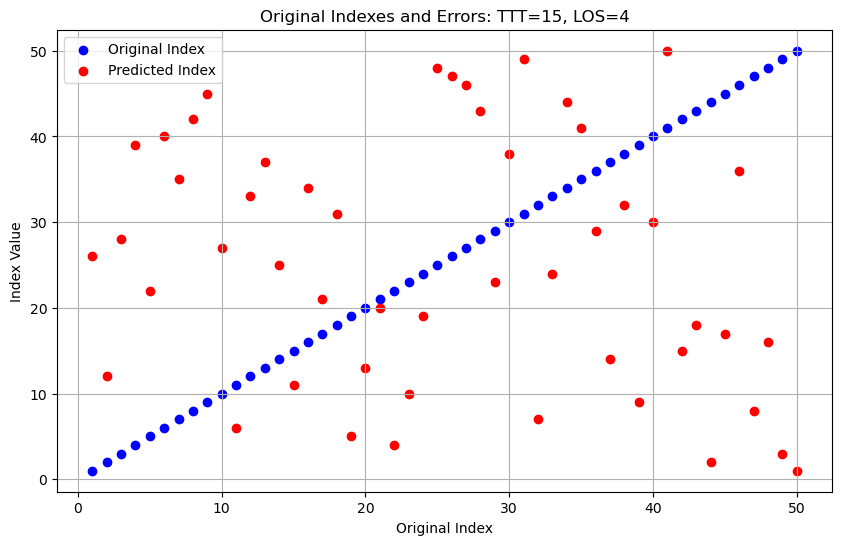

Accuracy rate for group TTT=15, LOS=4: 0.51


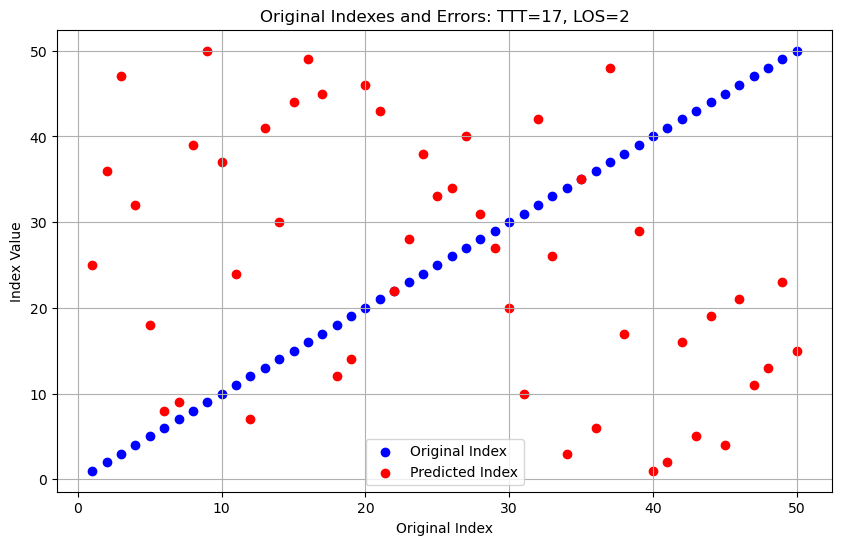

Accuracy rate for group TTT=17, LOS=2: 0.49


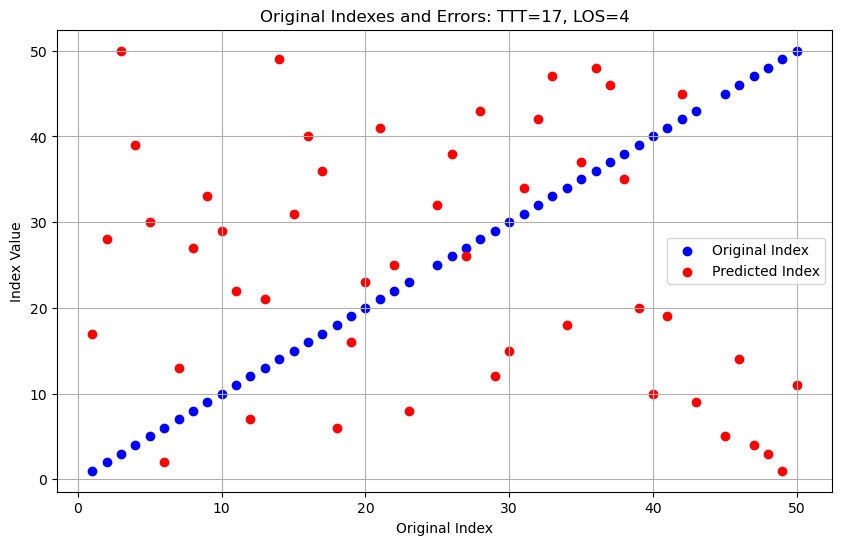

Accuracy rate for group TTT=17, LOS=4: 0.51


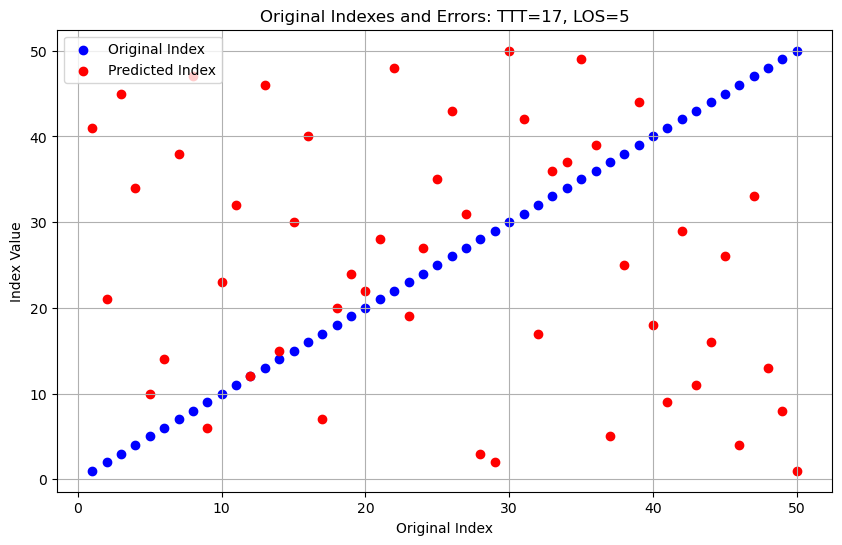

Accuracy rate for group TTT=17, LOS=5: 0.53


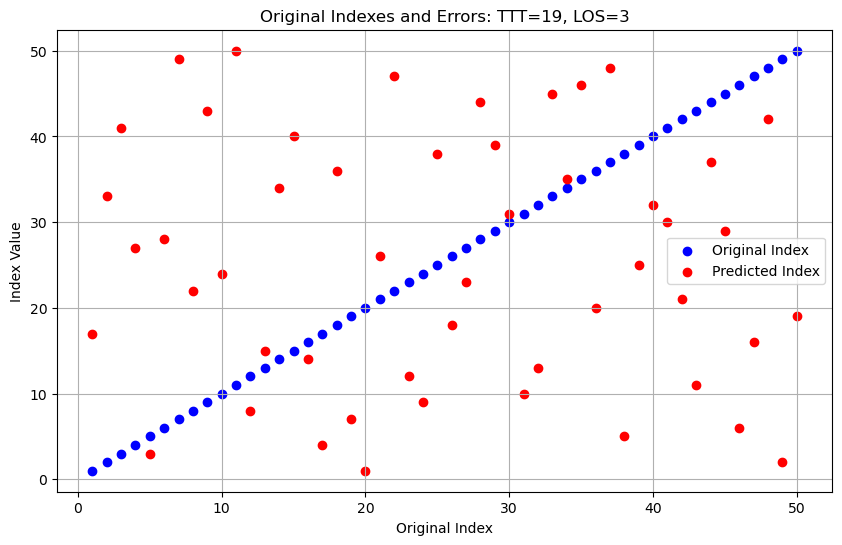

Accuracy rate for group TTT=19, LOS=3: 0.51
Average Error: 25110.9
Standard Deviation of Errors: 4492.112085645237


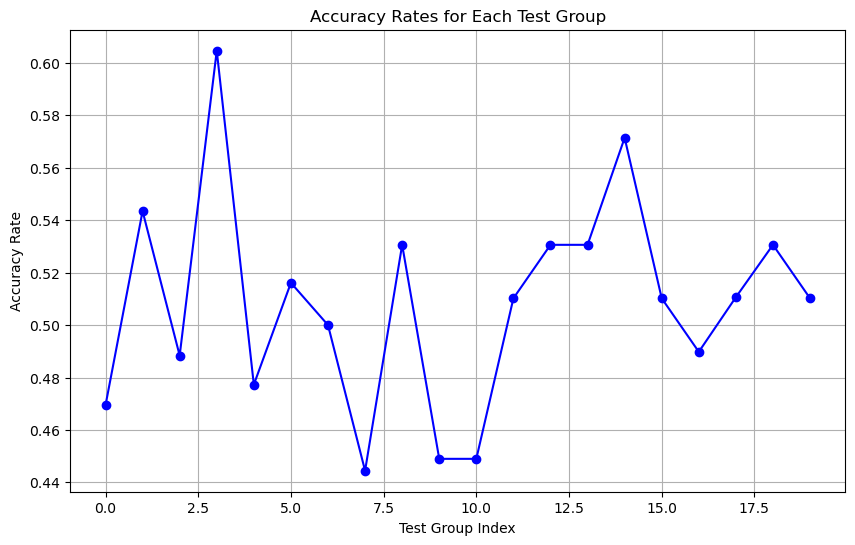

In [518]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Filter the dataset
df = df[(df['TTT'] >= 1) & (df['TTT'] <= 20) & (df['Index'] >= 1) & (df['Index'] <= 50)]
model_training_data = df[(df['TTT'] >= 1) & (df['TTT'] <= 20) & (df['Index'] >= 1) & (df['Index'] <= 50)]

# Split data into training and test sets based on TTT values
even_ttt = model_training_data[model_training_data['TTT'] % 2 == 0]
odd_ttt = model_training_data[model_training_data['TTT'] % 2 != 0]

print(f"sum of EVEN TTT unique groups: {even_ttt.groupby(['TTT', 'LOS']).ngroups}")
print(f"sum of ODD TTT unique groups: {odd_ttt.groupby(['TTT', 'LOS']).ngroups}")

# Select n unique groups for training
train_groups = even_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=50)
train_data = pd.merge(even_ttt, train_groups, on=['TTT', 'LOS'])

# Select n unique groups for testing
test_groups = odd_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=20)
test_data = pd.merge(odd_ttt, test_groups, on=['TTT', 'LOS'])

# Function to create features for a pair of hotels
def create_pair_features(hotel1, hotel2):
    features = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']
    pair_features = []
    for feature in features:
        pair_features.append(hotel1[feature] - hotel2[feature])
    return pair_features

# Function to generate random pairs and create a dataset
def generate_pair_dataset(df):
    np.random.seed(42)  # For reproducibility
    num_pairs = 10000  # Number of pairs to generate
    indices = np.random.choice(df.index, size=(num_pairs, 2), replace=True)
    
    data = []
    labels = []
    index_pairs = []
    
    for idx1, idx2 in indices:
        if idx1 == idx2:
            continue
        hotel1 = df.loc[idx1]
        hotel2 = df.loc[idx2]
        
        pair_features = create_pair_features(hotel1, hotel2)
        label = 1 if hotel1['Index'] > hotel2['Index'] else 0
        
        data.append(pair_features)
        labels.append(label)
        index_pairs.append((hotel1['Index'], hotel2['Index']))
    
    return pd.DataFrame(data, columns=[f'{f}_diff' for f in features]), np.array(labels), index_pairs

# Generate the dataset
X, y, index_pairs = generate_pair_dataset(train_data)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val, index_pairs_train, index_pairs_val = train_test_split(X, y, index_pairs, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_pred = clf.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy Score:", accuracy)

# Function to compare two hotels using the trained model
def compare_hotels(hotel1, hotel2):
    pair_features = create_pair_features(hotel1, hotel2)
    prediction = clf.predict([pair_features])
    return 1 if prediction[0] else -1

# Bubble Sort using the model
def bubble_sort_hotels(hotels):
    n = len(hotels)
    for i in range(n):
        for j in range(0, n-i-1):
            if compare_hotels(hotels.iloc[j], hotels.iloc[j+1]) == -1:
                hotels.iloc[j], hotels.iloc[j+1] = hotels.iloc[j+1], hotels.iloc[j]
    return hotels

# Calculate the sum of squared index differences
errors = []
accuracy_rates = []

for name, group in test_data.groupby(['TTT', 'LOS']):
    original_indices = group['Index'].values
    shuffled_group = group.sample(frac=1).reset_index(drop=True)
    sorted_group = bubble_sort_hotels(shuffled_group)
    sorted_indices = sorted_group['Index'].values
    error = np.sum((sorted_indices - original_indices)**2)
    errors.append(error)

    # Calculate accuracy
    correct_predictions = sum((sorted_indices[i] < sorted_indices[i+1]) == (original_indices[i] < original_indices[i+1])
                              for i in range(len(sorted_indices) - 1))
    accuracy_rate = correct_predictions / (len(sorted_indices) - 1)
    accuracy_rates.append(accuracy_rate)

    # Plot the original indexes as blue points and the errors as red points for each original index
    plt.figure(figsize=(10, 6))
    plt.scatter(original_indices, original_indices, color='blue', label='Original Index')
    plt.scatter(original_indices, sorted_indices, color='red', label='Predicted Index')
    plt.title(f'Original Indexes and Errors: TTT={group["TTT"].values[0]}, LOS={group["LOS"].values[0]}')
    plt.xlabel('Original Index')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Accuracy rate for group TTT={group['TTT'].values[0]}, LOS={group['LOS'].values[0]}: {accuracy_rate:.2f}")

# Calculate the average and standard deviation of errors
avg_error = np.mean(errors)
std_error = np.std(errors)

# Display the results
print(f'Average Error: {avg_error}')
print(f'Standard Deviation of Errors: {std_error}')

# Plot the overall accuracy rates
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_rates)), accuracy_rates, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Rates for Each Test Group')
plt.xlabel('Test Group Index')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


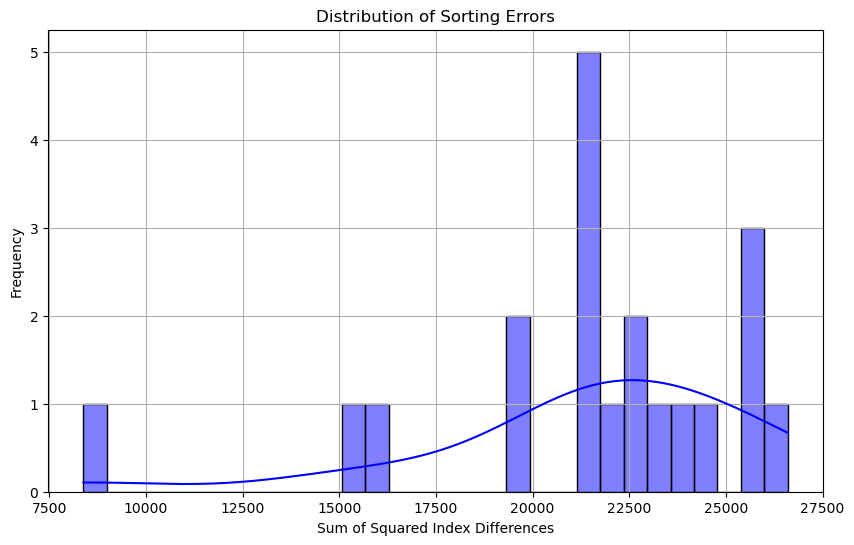

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'errors' list is already calculated as before

# Plot the errors using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='blue')
plt.title('Distribution of Sorting Errors')
plt.xlabel('Sum of Squared Index Differences')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Repeat the process but with other model: Random Forest

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       942
           1       0.00      0.00      0.00        24

    accuracy                           0.98       966
   macro avg       0.49      0.50      0.49       966
weighted avg       0.95      0.98      0.96       966

Accuracy Score: 0.9751552795031055


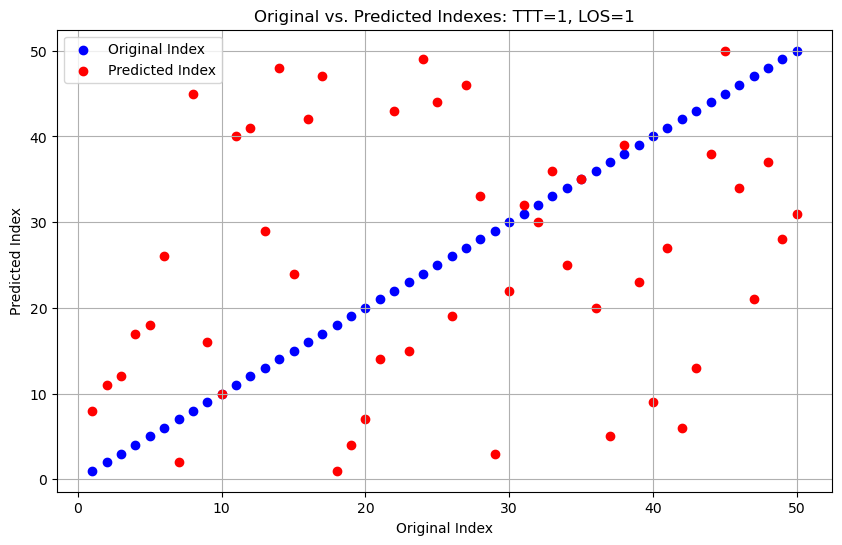

Accuracy rate for group TTT=1, LOS=1: 0.57


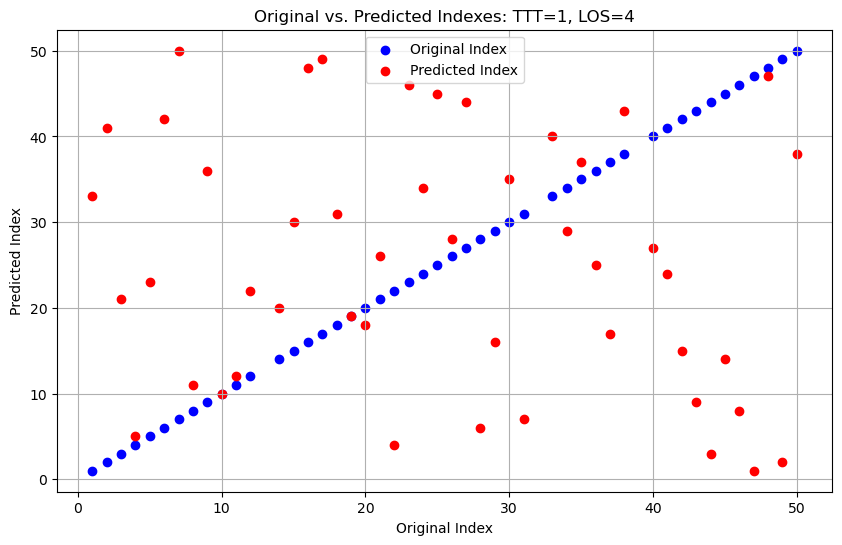

Accuracy rate for group TTT=1, LOS=4: 0.48


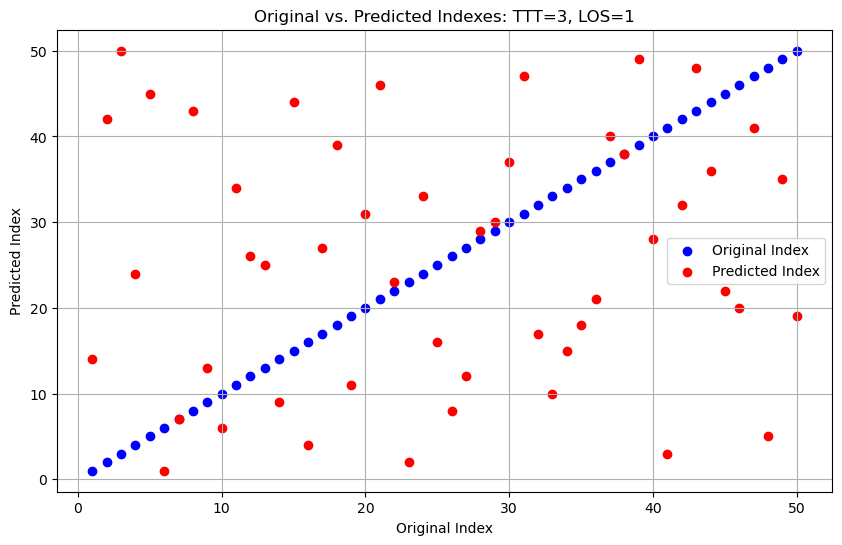

Accuracy rate for group TTT=3, LOS=1: 0.53


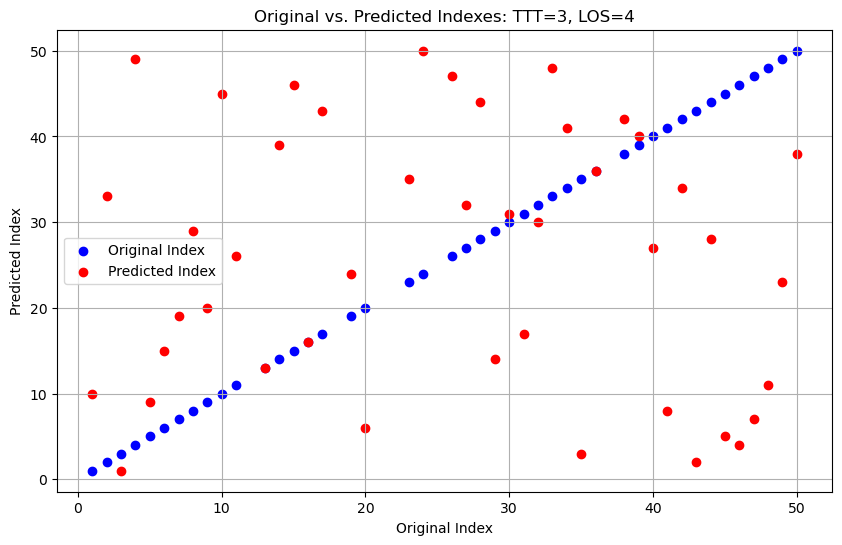

Accuracy rate for group TTT=3, LOS=4: 0.53


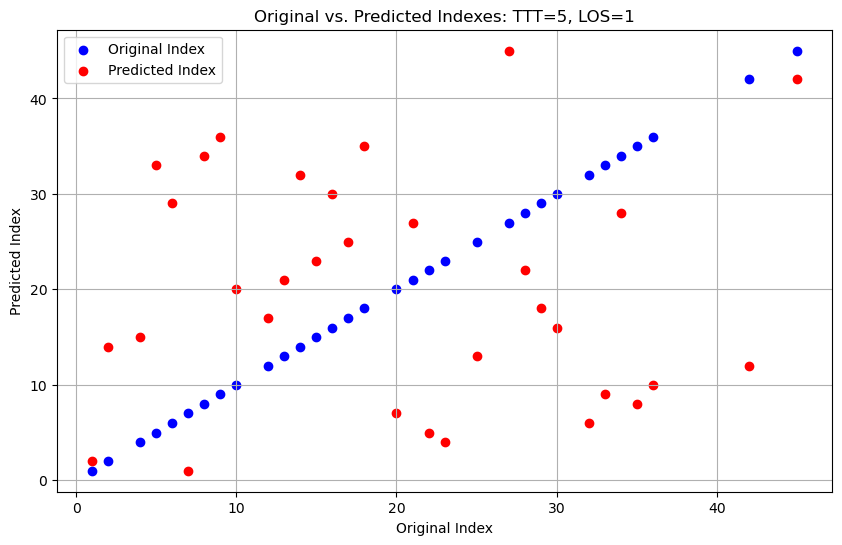

Accuracy rate for group TTT=5, LOS=1: 0.55


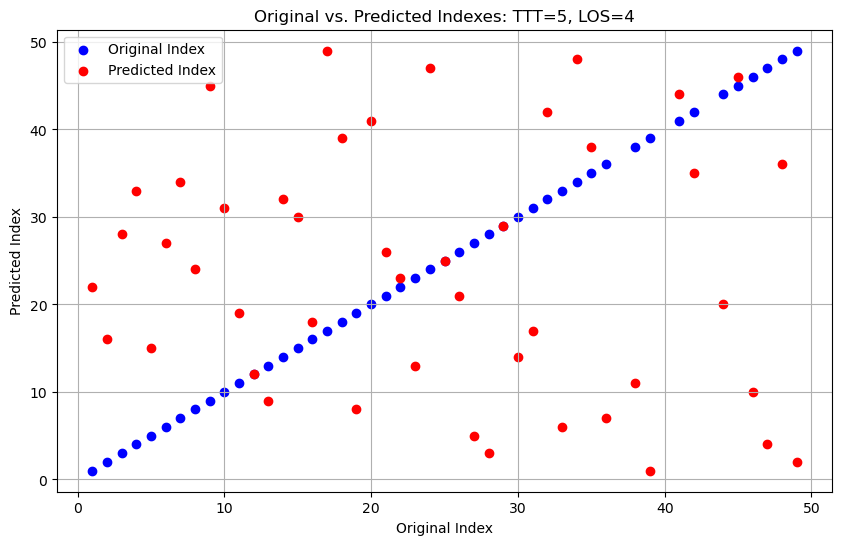

Accuracy rate for group TTT=5, LOS=4: 0.38


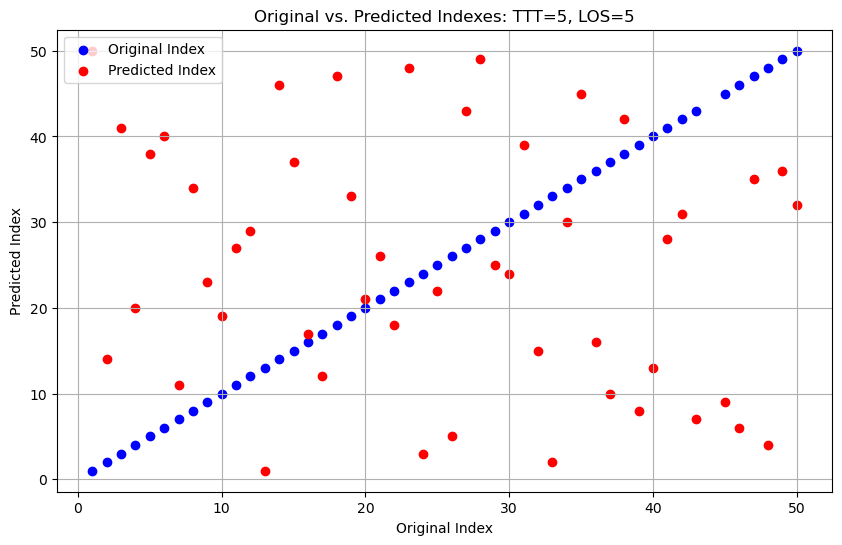

Accuracy rate for group TTT=5, LOS=5: 0.48


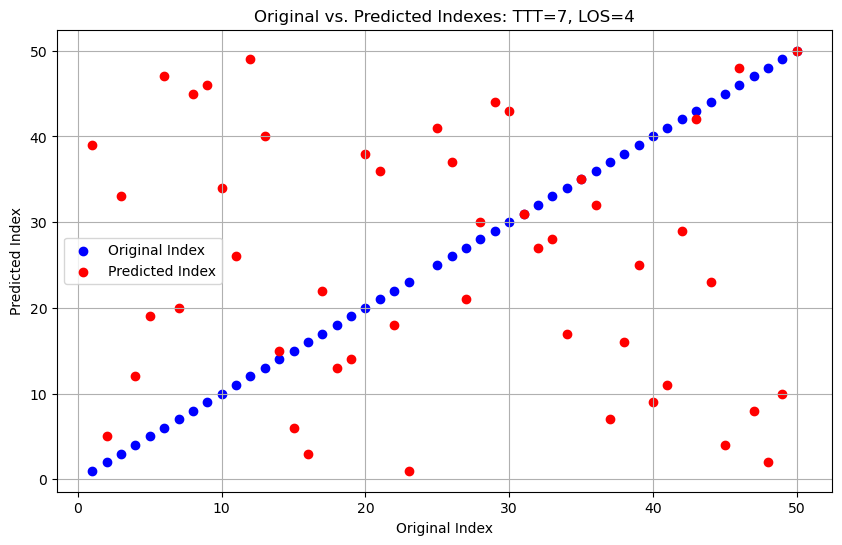

Accuracy rate for group TTT=7, LOS=4: 0.46


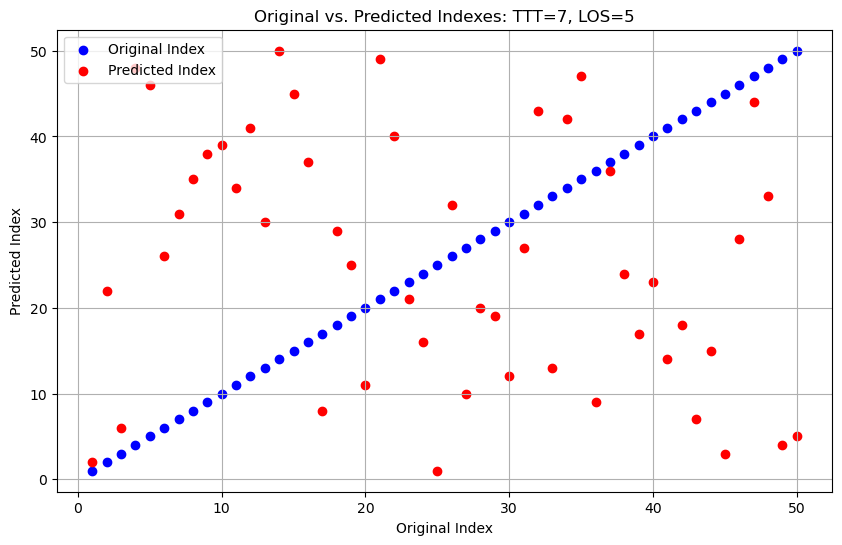

Accuracy rate for group TTT=7, LOS=5: 0.47


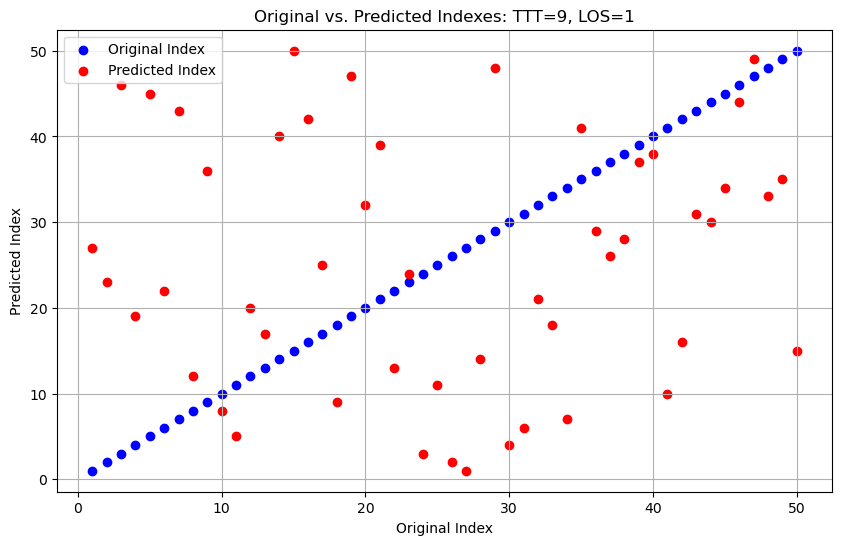

Accuracy rate for group TTT=9, LOS=1: 0.51


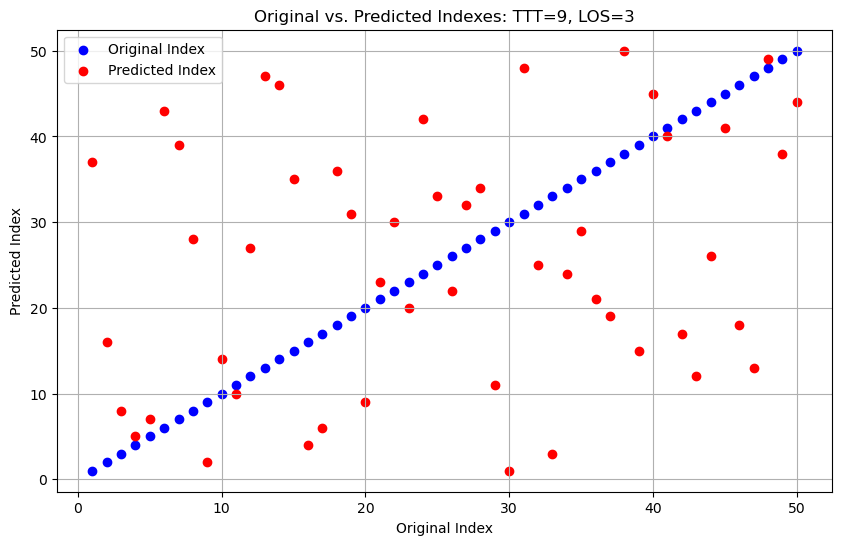

Accuracy rate for group TTT=9, LOS=3: 0.43


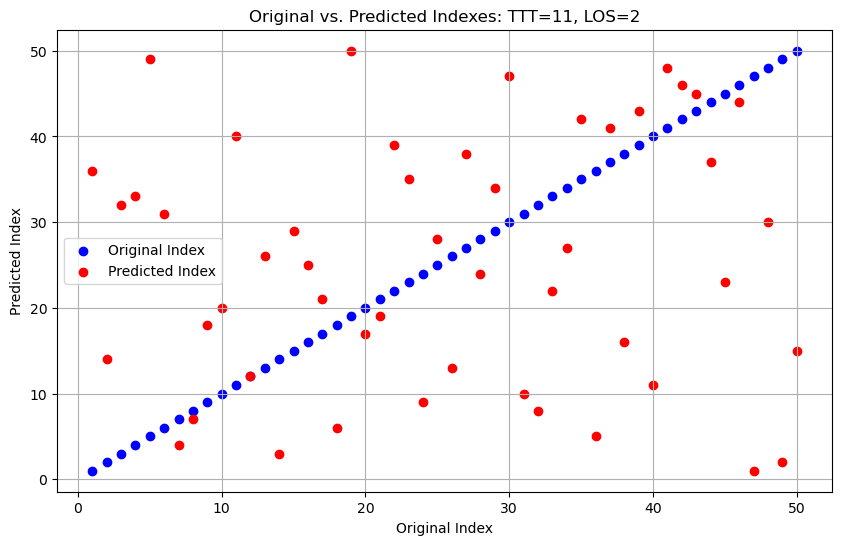

Accuracy rate for group TTT=11, LOS=2: 0.51


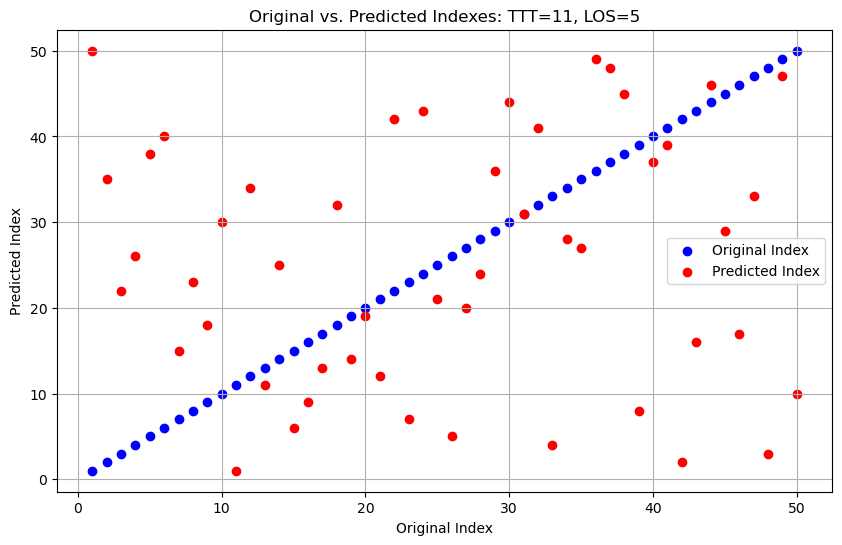

Accuracy rate for group TTT=11, LOS=5: 0.53


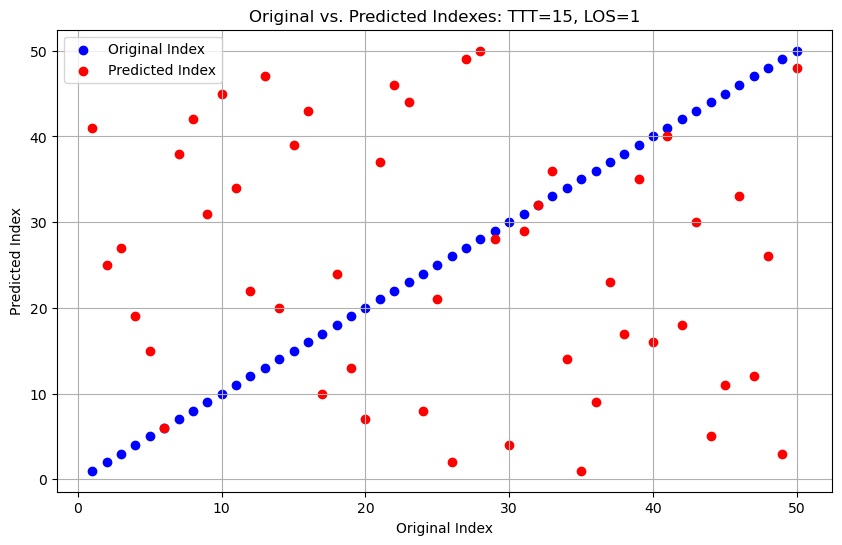

Accuracy rate for group TTT=15, LOS=1: 0.51


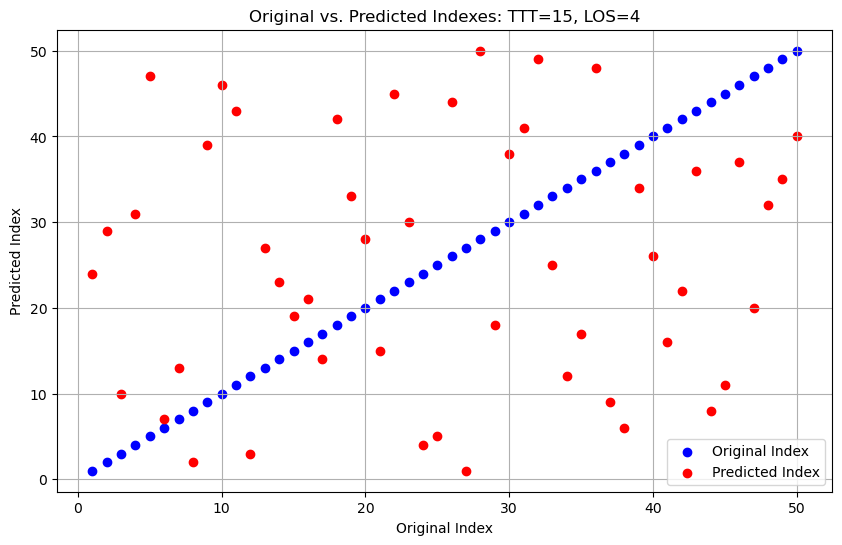

Accuracy rate for group TTT=15, LOS=4: 0.53


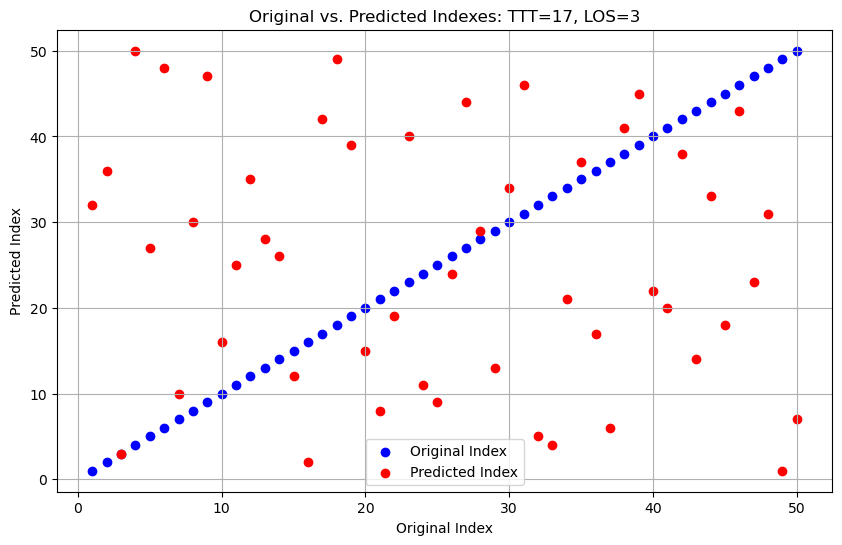

Accuracy rate for group TTT=17, LOS=3: 0.49


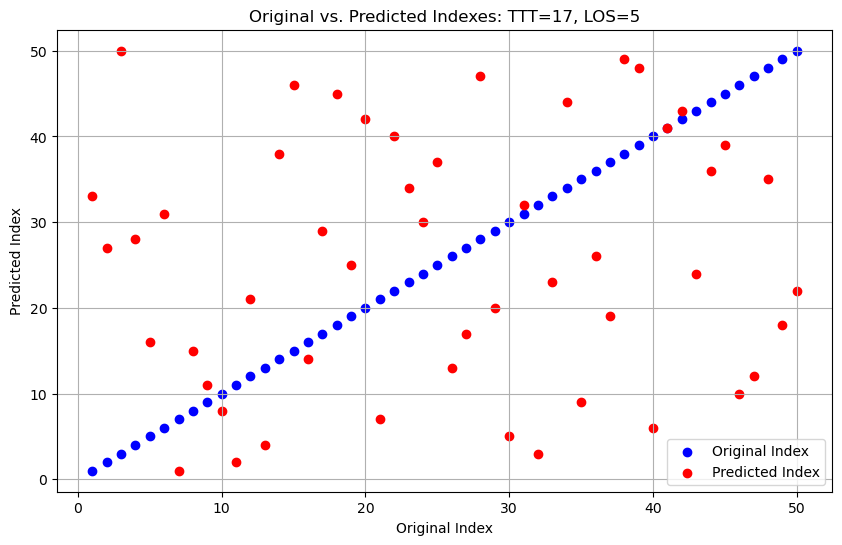

Accuracy rate for group TTT=17, LOS=5: 0.51


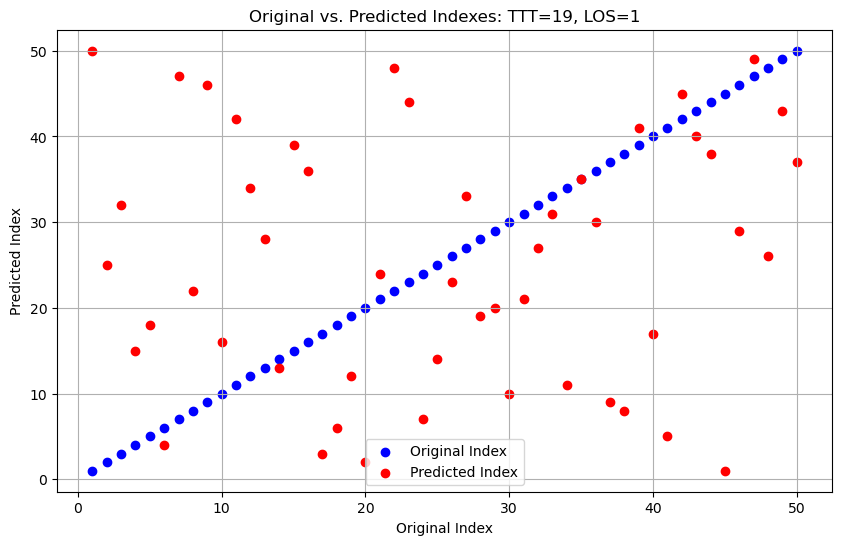

Accuracy rate for group TTT=19, LOS=1: 0.47


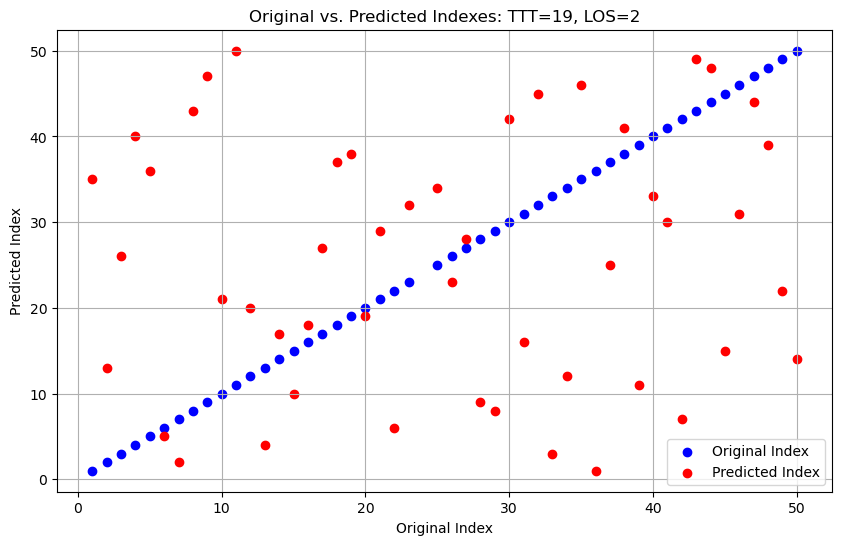

Accuracy rate for group TTT=19, LOS=2: 0.50


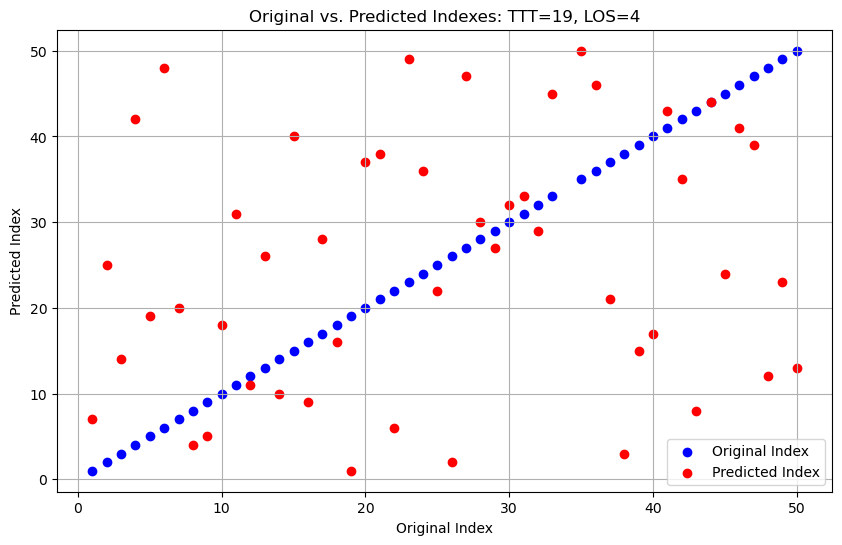

Accuracy rate for group TTT=19, LOS=4: 0.48
Average Error: 20382.9
Standard Deviation of Errors: 3732.1478253145337


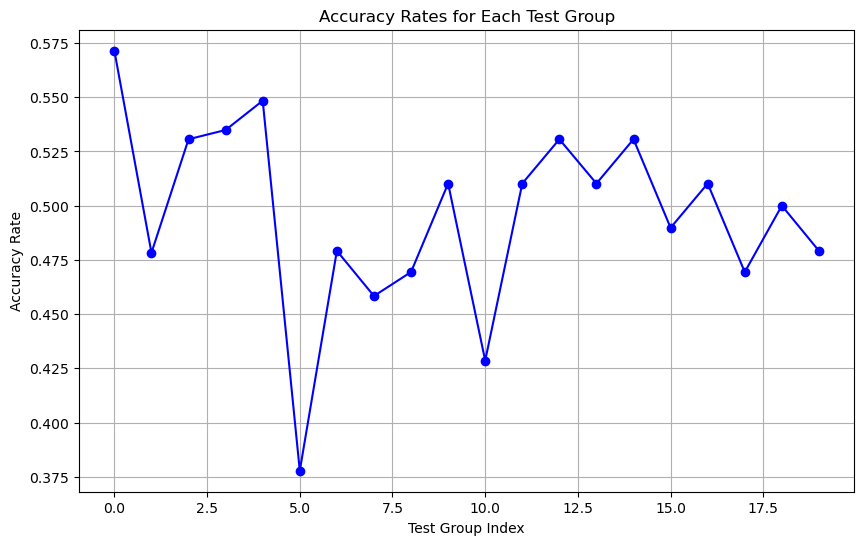

In [434]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Function to compare two hotels using the trained model
def compare_hotels(hotel1, hotel2):
    features = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']
    pair = pd.DataFrame([hotel1[features], hotel2[features]])
    prediction = clf.predict(pair)
    return 1 if prediction[0] else -1

# Bubble Sort using the model
def bubble_sort_hotels(hotels):
    n = len(hotels)
    for i in range(n):
        for j in range(0, n-i-1):
            if compare_hotels(hotels.iloc[j], hotels.iloc[j+1]) == -1:
                hotels.iloc[j], hotels.iloc[j+1] = hotels.iloc[j+1], hotels.iloc[j]
    return hotels 

# Define features and target for the model
features = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']
X = model_trainning_data[features]
y = (model_trainning_data['Index'].diff().shift(-1) < 0).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Perform error analysis and sorting
errors = []
accuracy_rates = []

for name, group in test_data.groupby(['TTT', 'LOS']):
    original_indices = group['Index'].values
    shuffled_group = group.sample(frac=1).reset_index(drop=True)
    sorted_group = bubble_sort_hotels(shuffled_group)
    sorted_indices = sorted_group['Index'].values
    error = np.sum((sorted_indices - original_indices)**2)
    errors.append(error)

    correct_predictions = sum((sorted_indices[i] < sorted_indices[i+1]) == (original_indices[i] < original_indices[i+1])
                              for i in range(len(sorted_indices) - 1))
    accuracy_rate = correct_predictions / (len(sorted_indices) - 1)
    accuracy_rates.append(accuracy_rate)

    plt.figure(figsize=(10, 6))
    plt.scatter(original_indices, original_indices, color='blue', label='Original Index')
    plt.scatter(original_indices, sorted_indices, color='red', label='Predicted Index')
    plt.title(f'Original vs. Predicted Indexes: TTT={group["TTT"].values[0]}, LOS={group["LOS"].values[0]}')
    plt.xlabel('Original Index')
    plt.ylabel('Predicted Index')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Accuracy rate for group TTT={group['TTT'].values[0]}, LOS={group['LOS'].values[0]}: {accuracy_rate:.2f}")

# Calculate average and standard deviation of errors
avg_error = np.mean(errors)
std_error = np.std(errors) 

print(f'Average Error: {avg_error}')
print(f'Standard Deviation of Errors: {std_error}')

plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_rates)), accuracy_rates, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Rates for Each Test Group')
plt.xlabel('Test Group Index')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()

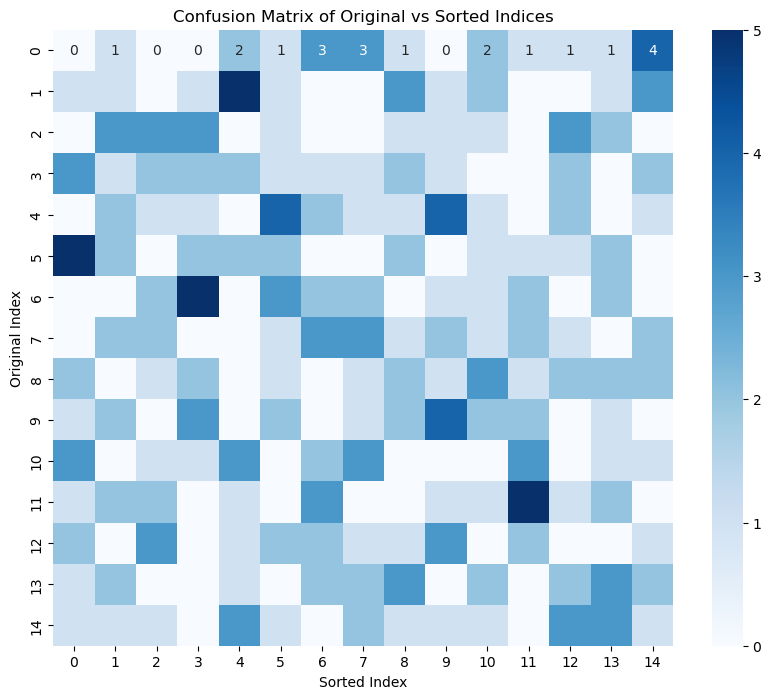

In [345]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_original_indices, all_sorted_indices)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Original vs Sorted Indices')
plt.xlabel('Sorted Index')
plt.ylabel('Original Index')
plt.show()

In [346]:
# Display the results
print(f'Average Error: {avg_error}')
print(f'Standard Deviation of Errors: {std_error}')

Average Error: 20458.8
Standard Deviation of Errors: 1114.3825913930996


C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


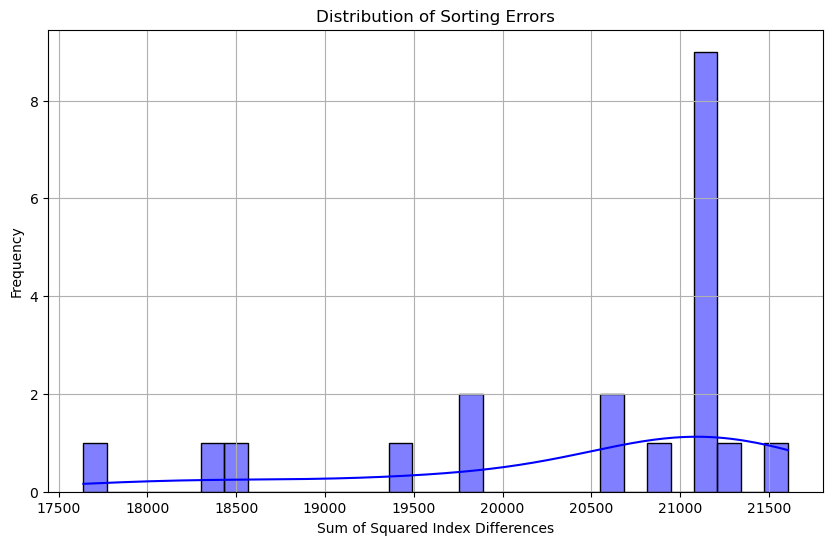

In [347]:
# Plot the errors using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='blue')
plt.title('Distribution of Sorting Errors')
plt.xlabel('Sum of Squared Index Differences')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

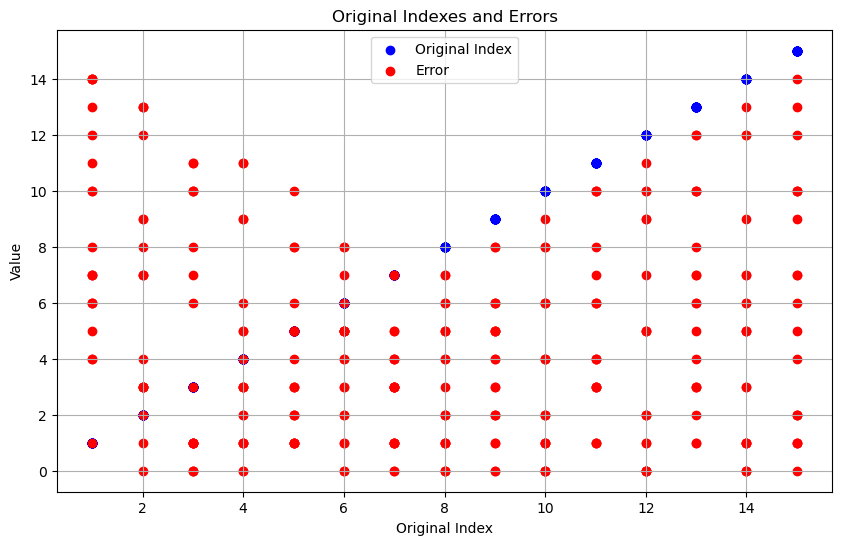

In [348]:
# Plot the original indexes as blue points and the errors as red points for each original index
plt.figure(figsize=(10, 6))
plt.scatter(all_original_indices, all_original_indices, color='blue', label='Original Index')
plt.scatter(all_original_indices, np.abs(np.array(all_original_indices) - np.array(all_sorted_indices)), color='red', label='Error')
plt.title('Original Indexes and Errors')
plt.xlabel('Original Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

sum of EVEN TTT unique groups: 50
sum of ODD TTT unique groups: 50
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


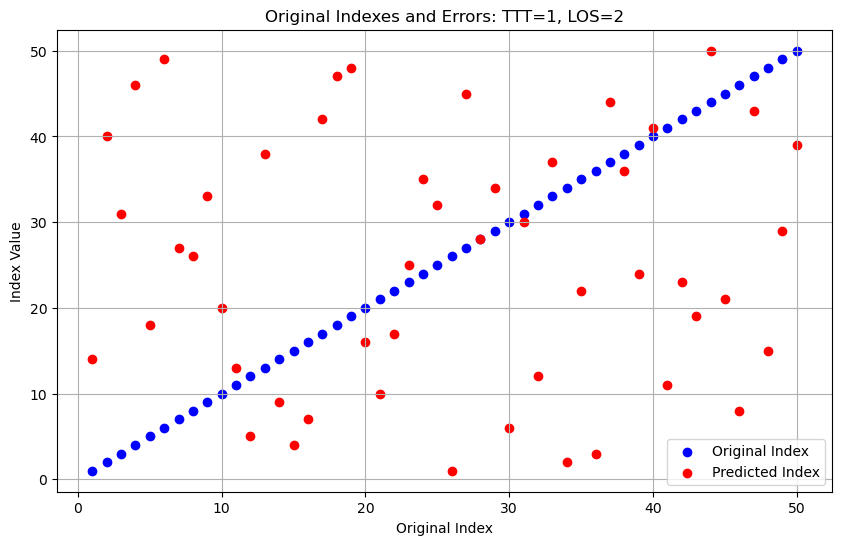

Accuracy rate for group TTT=1, LOS=2: 0.49


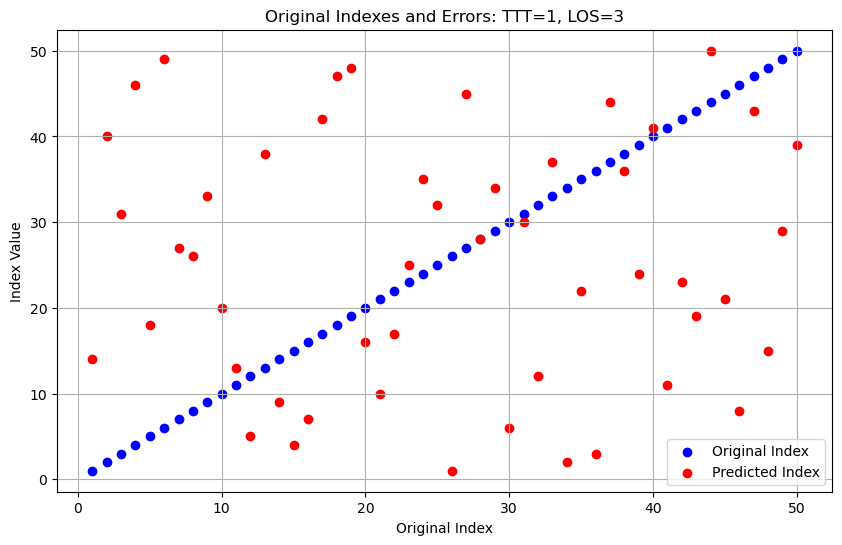

Accuracy rate for group TTT=1, LOS=3: 0.49


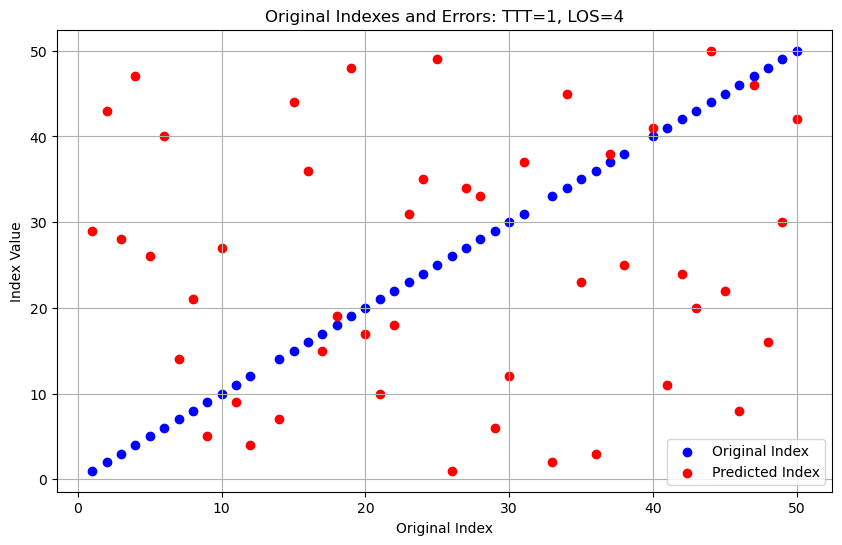

Accuracy rate for group TTT=1, LOS=4: 0.52


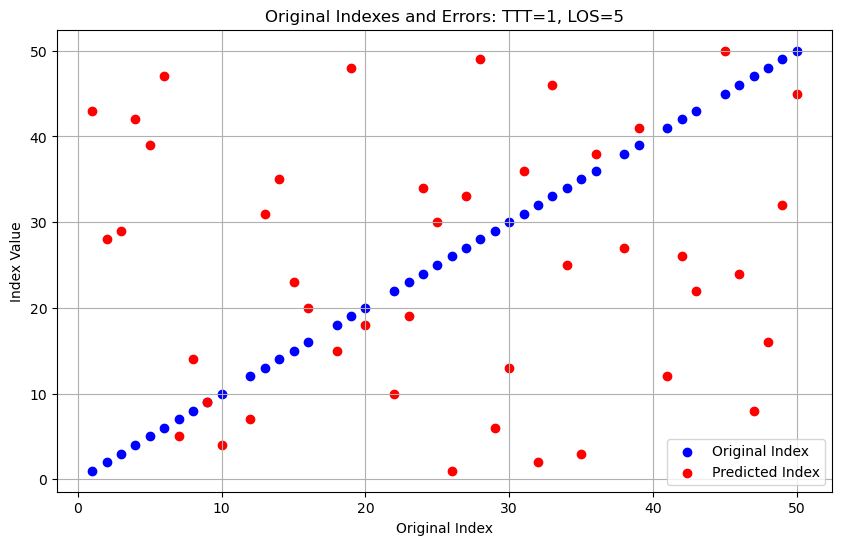

Accuracy rate for group TTT=1, LOS=5: 0.51


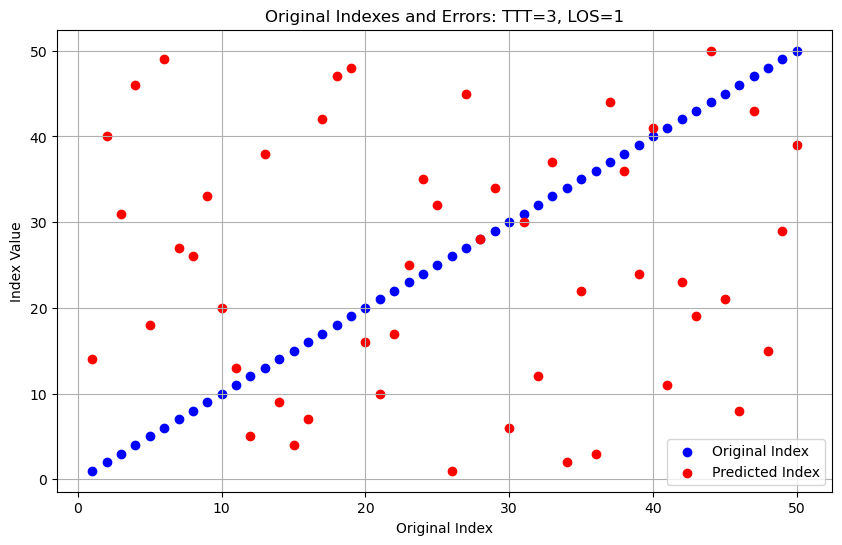

Accuracy rate for group TTT=3, LOS=1: 0.49


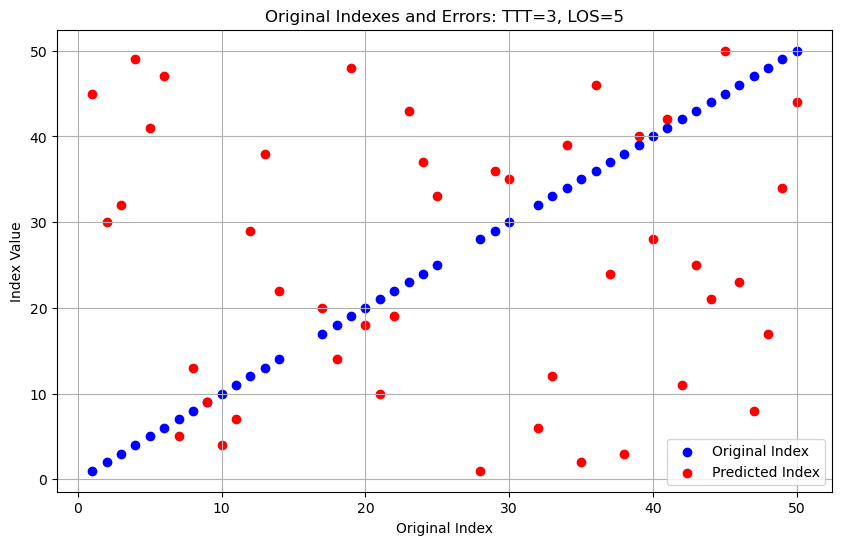

Accuracy rate for group TTT=3, LOS=5: 0.48


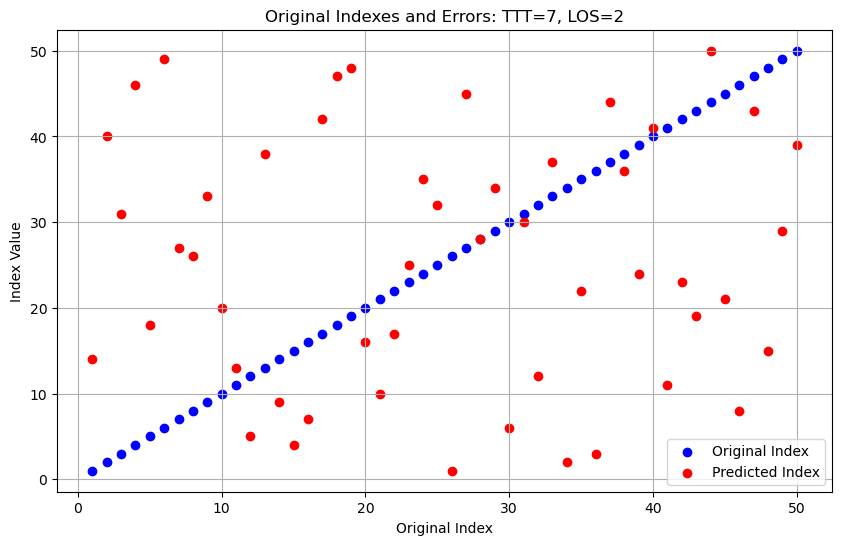

Accuracy rate for group TTT=7, LOS=2: 0.49


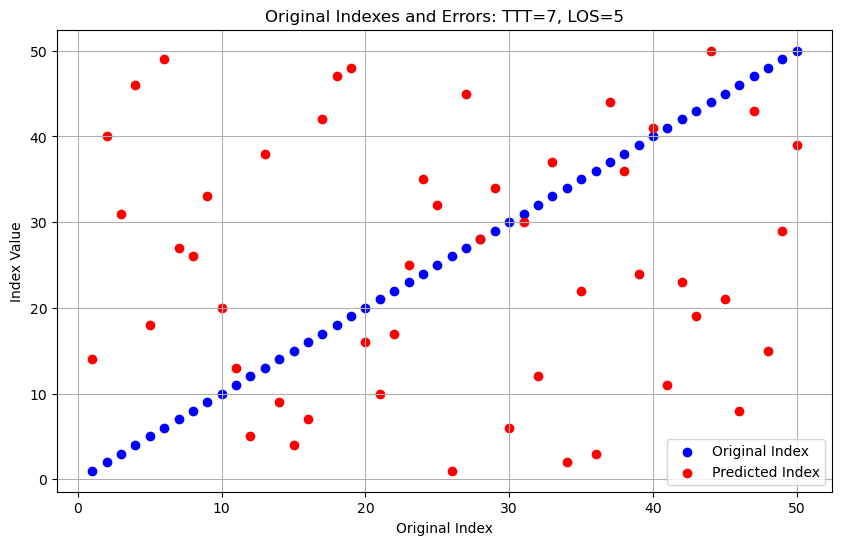

Accuracy rate for group TTT=7, LOS=5: 0.49


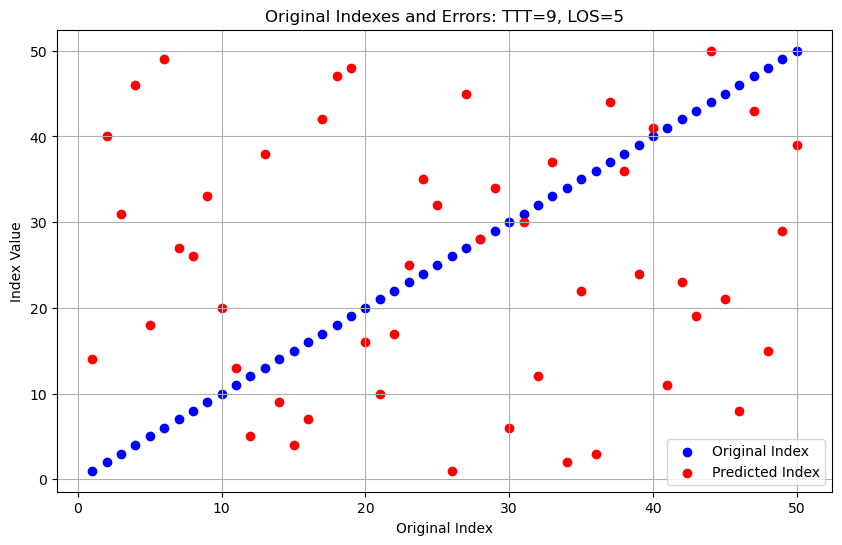

Accuracy rate for group TTT=9, LOS=5: 0.49


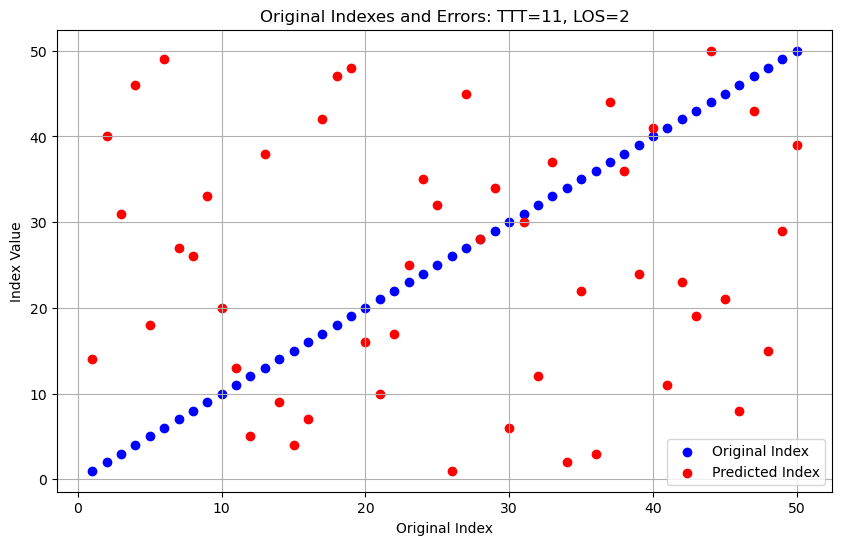

Accuracy rate for group TTT=11, LOS=2: 0.49


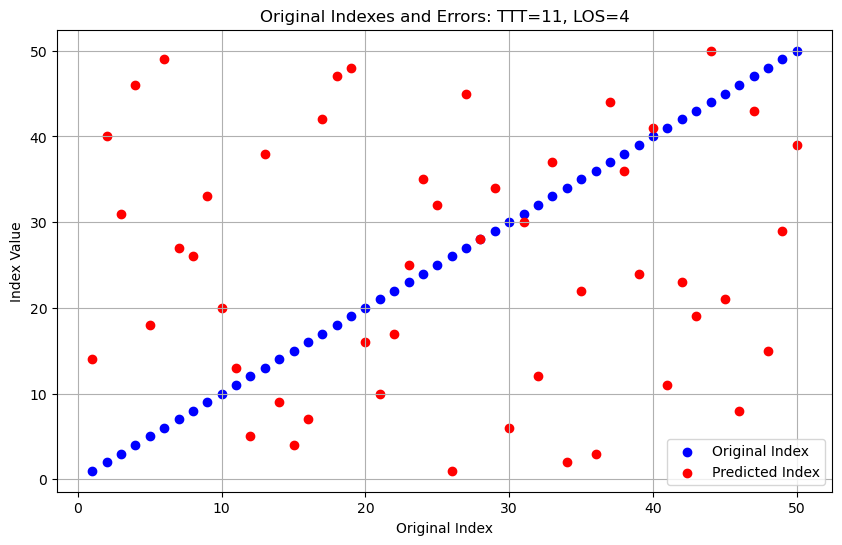

Accuracy rate for group TTT=11, LOS=4: 0.49


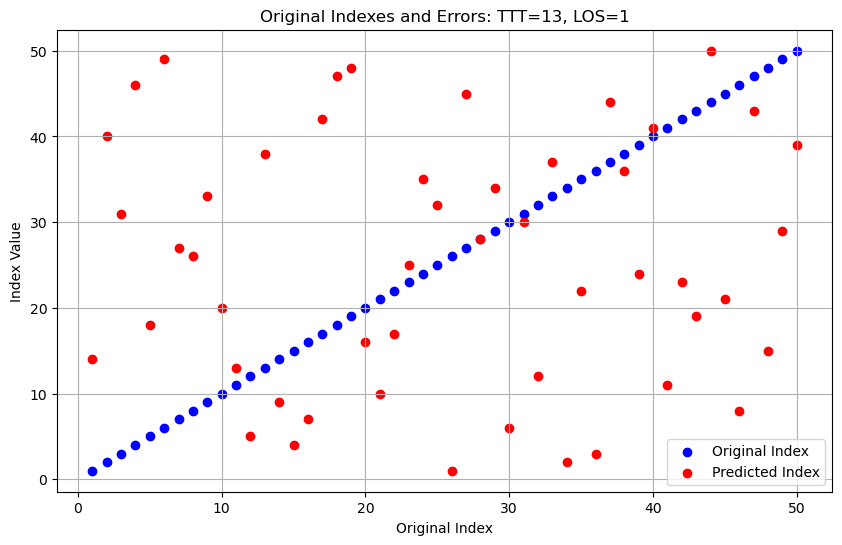

Accuracy rate for group TTT=13, LOS=1: 0.49


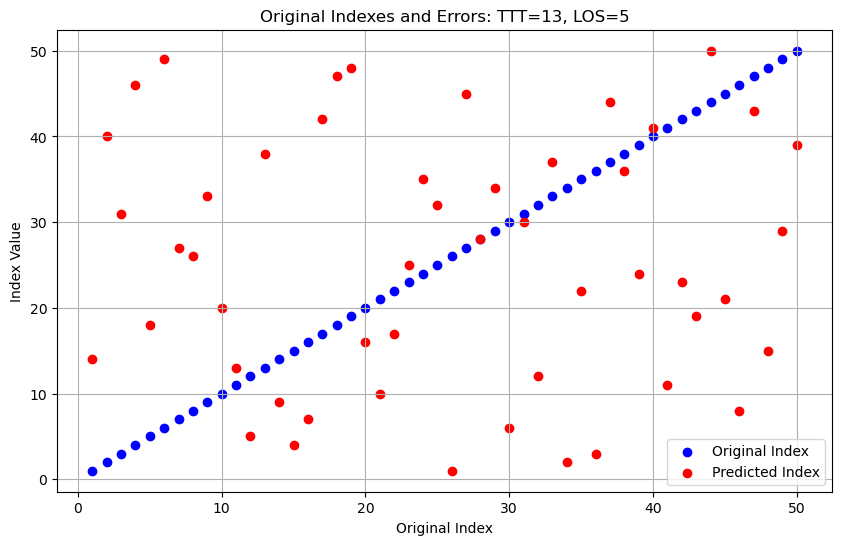

Accuracy rate for group TTT=13, LOS=5: 0.49


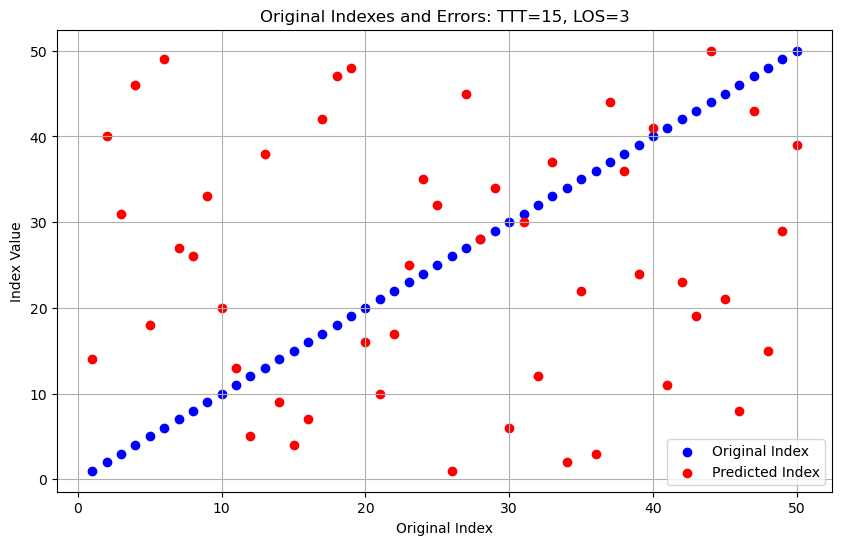

Accuracy rate for group TTT=15, LOS=3: 0.49


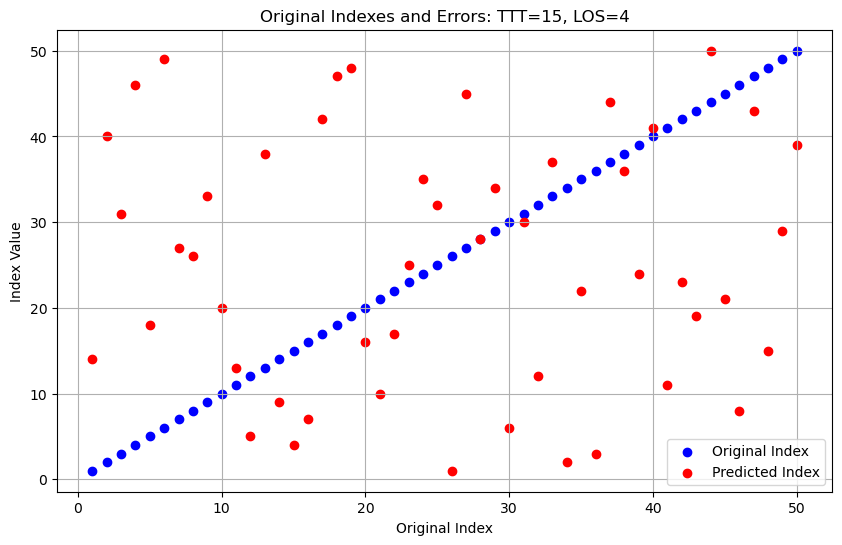

Accuracy rate for group TTT=15, LOS=4: 0.49


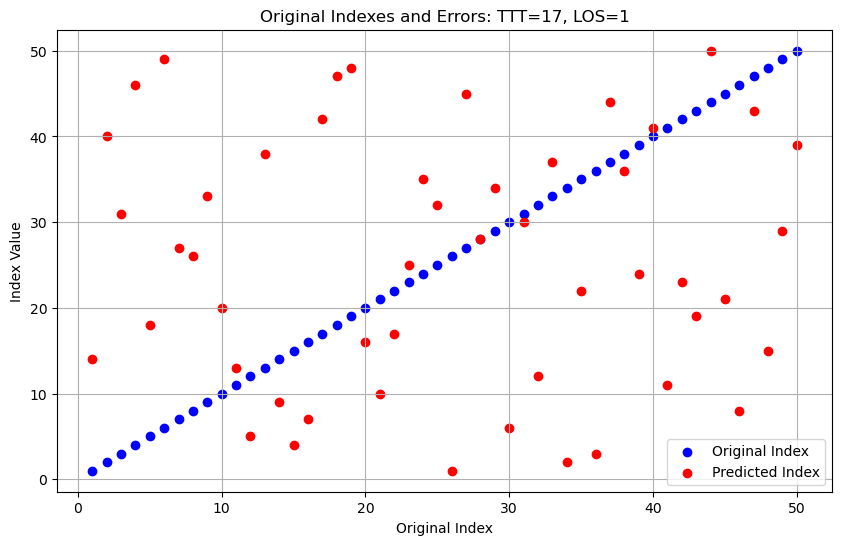

Accuracy rate for group TTT=17, LOS=1: 0.49


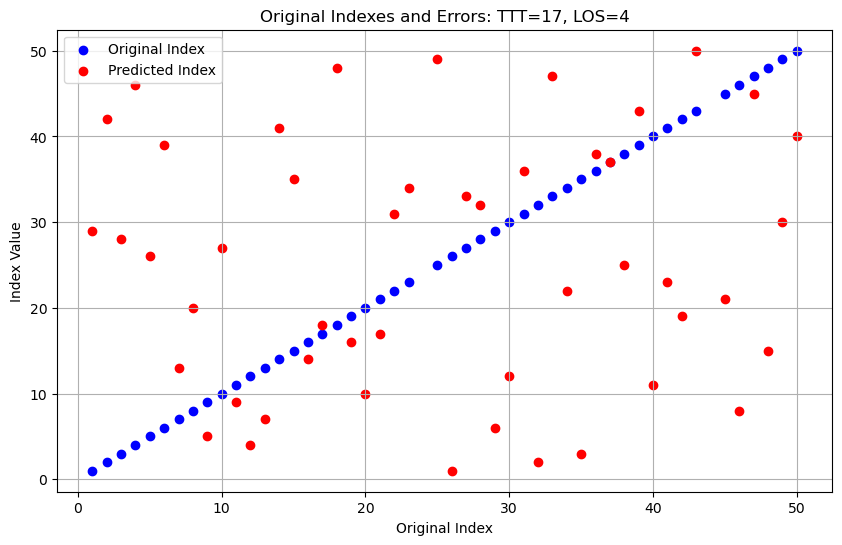

Accuracy rate for group TTT=17, LOS=4: 0.51


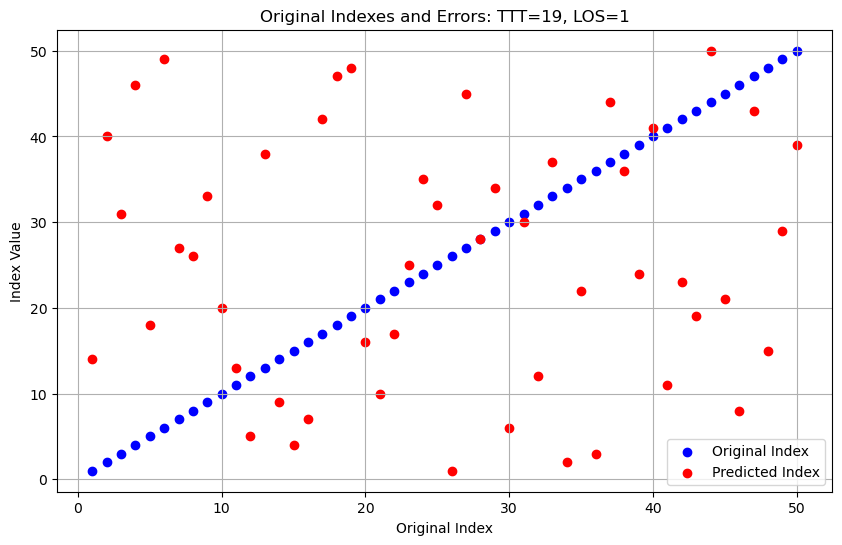

Accuracy rate for group TTT=19, LOS=1: 0.49


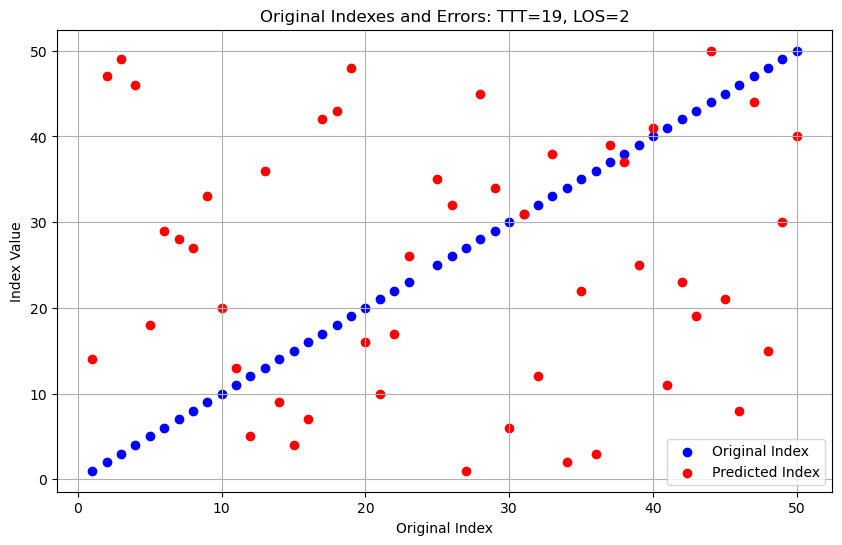

Accuracy rate for group TTT=19, LOS=2: 0.48


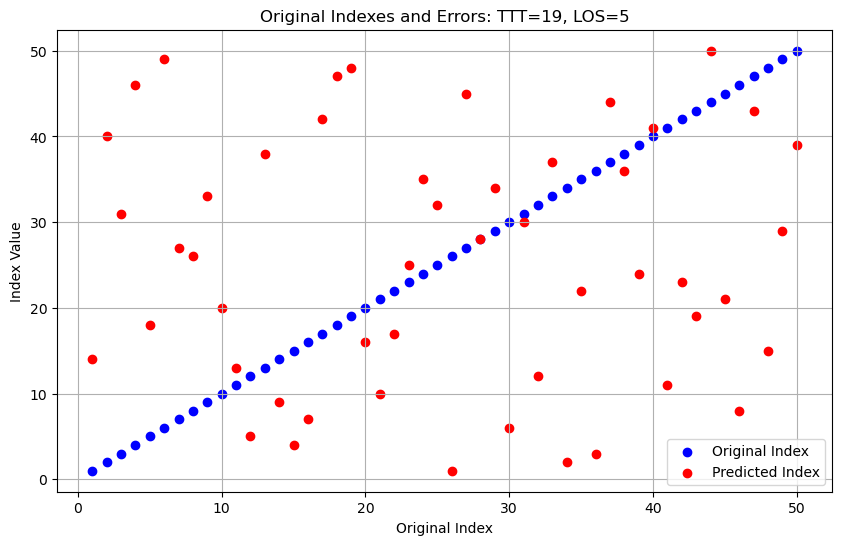

Accuracy rate for group TTT=19, LOS=5: 0.49
Average Error: 20864.0
Standard Deviation of Errors: 762.0178475600161


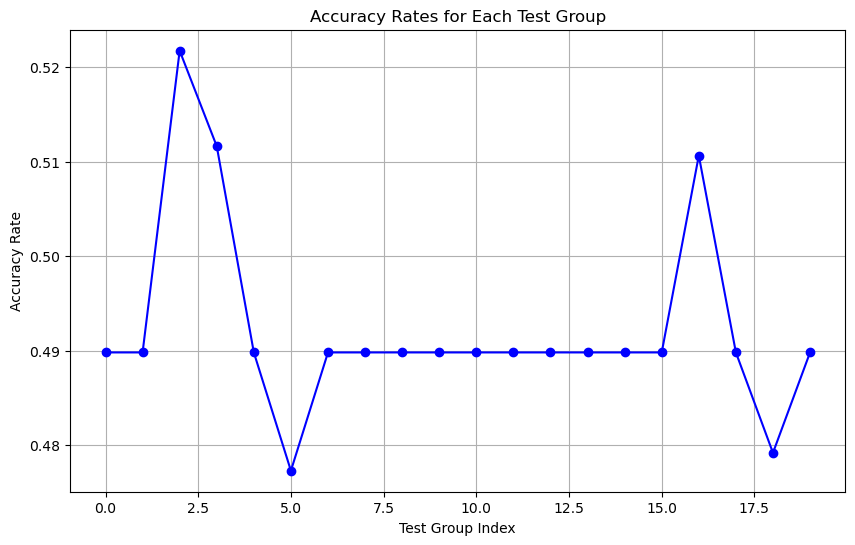

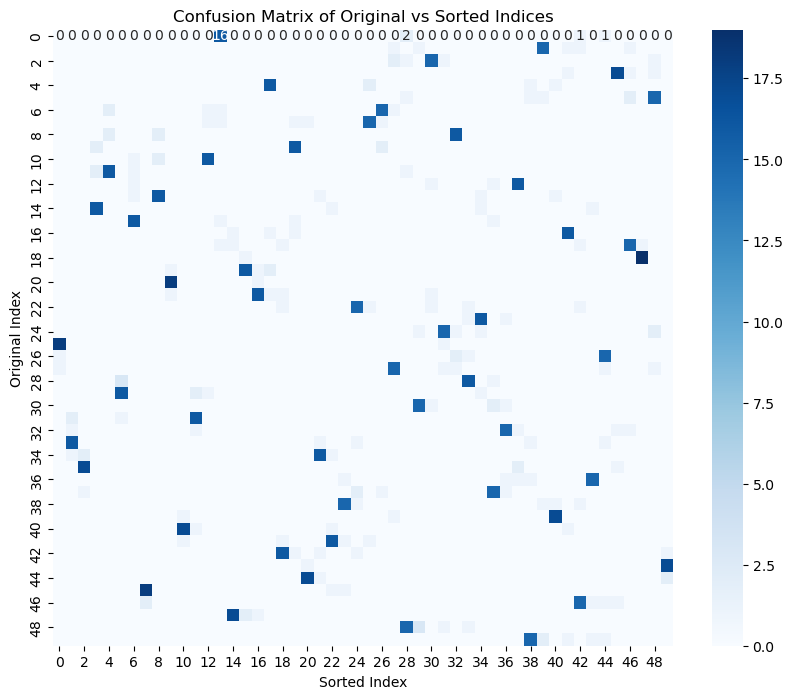

In [382]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature columns
feature_columns = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']

# Assuming df is your DataFrame
# Split data into training and test sets based on TTT values
even_ttt = df[df['TTT'] % 2 == 0]
odd_ttt = df[df['TTT'] % 2 != 0]

print(f"sum of EVEN TTT unique groups: {even_ttt.groupby(['TTT', 'LOS']).ngroups}")
print(f"sum of ODD TTT unique groups: {odd_ttt.groupby(['TTT', 'LOS']).ngroups}")

# Select n unique groups for training
train_groups = even_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=50)
train_data = pd.merge(even_ttt, train_groups, on=['TTT', 'LOS'])

# Select n unique groups for testing
test_groups = odd_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=20)
test_data = pd.merge(odd_ttt, test_groups, on=['TTT', 'LOS'])

# Prepare training data for the classifier
train_X = train_data[feature_columns]
train_y = (train_data['Index'].diff().shift(-1) < 0).astype(int)

# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

# Best parameters from grid search
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Function to predict the order of two hotels
def predict_order(hotel1, hotel2):
    pair = pd.DataFrame([hotel1, hotel2])
    pair = pair[feature_columns]
    prediction = best_rf.predict(pair)
    return 1 if prediction[0] else -1

# Function to perform Bubble Sort based on the prediction model
def bubble_sort_hotels(hotels):
    sorted_hotels = hotels.copy()
    n = len(sorted_hotels)
    for i in range(n):
        for j in range(0, n-i-1):
            hotel1 = sorted_hotels.iloc[j]
            hotel2 = sorted_hotels.iloc[j+1]
            if predict_order(hotel1, hotel2) == 1:
                sorted_hotels.iloc[j], sorted_hotels.iloc[j+1] = sorted_hotels.iloc[j+1], sorted_hotels.iloc[j]
    return sorted_hotels

# Calculate the error and accuracy for the test data
errors = []
accuracy_rates = []

test_groups = test_data.groupby(['TTT', 'LOS'])
for name, group in test_groups:
    original_indices = group['Index'].values
    shuffled_group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    sorted_group = bubble_sort_hotels(shuffled_group)
    sorted_indices = sorted_group['Index'].values

    error = np.sum((original_indices - sorted_indices) ** 2)
    errors.append(error)

    # Calculate accuracy
    correct_predictions = sum((sorted_indices[i] < sorted_indices[i+1]) == (original_indices[i] < original_indices[i+1])
                              for i in range(len(sorted_indices) - 1))
    accuracy_rate = correct_predictions / (len(sorted_indices) - 1)
    accuracy_rates.append(accuracy_rate)

    # Plot the original indexes as blue points and the errors as red points for each original index
    plt.figure(figsize=(10, 6))
    plt.scatter(original_indices, original_indices, color='blue', label='Original Index')
    plt.scatter(original_indices, sorted_indices, color='red', label='Predicted Index')
    plt.title(f'Original Indexes and Errors: TTT={group["TTT"].values[0]}, LOS={group["LOS"].values[0]}')
    plt.xlabel('Original Index')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Accuracy rate for group TTT={group['TTT'].values[0]}, LOS={group['LOS'].values[0]}: {accuracy_rate:.2f}")

# Calculate the average and standard deviation of errors
avg_error = np.mean(errors)
std_error = np.std(errors)

# Display the results
print(f'Average Error: {avg_error}')
print(f'Standard Deviation of Errors: {std_error}')

# Plot the overall accuracy rates
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_rates)), accuracy_rates, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Rates for Each Test Group')
plt.xlabel('Test Group Index')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()

# Calculate the confusion matrix
all_original_indices = []
all_sorted_indices = []

for name, group in test_groups:
    original_indices = group['Index'].values
    shuffled_group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    sorted_group = bubble_sort_hotels(shuffled_group)
    sorted_indices = sorted_group['Index'].values
    all_original_indices.extend(original_indices)
    all_sorted_indices.extend(sorted_indices)

conf_matrix = confusion_matrix(all_original_indices, all_sorted_indices)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Original vs Sorted Indices')
plt.xlabel('Sorted Index')
plt.ylabel('Original Index')
plt.show()


# Repeat the process but with other model: KNN

sum of EVEN TTT unique groups: 50
sum of ODD TTT unique groups: 50


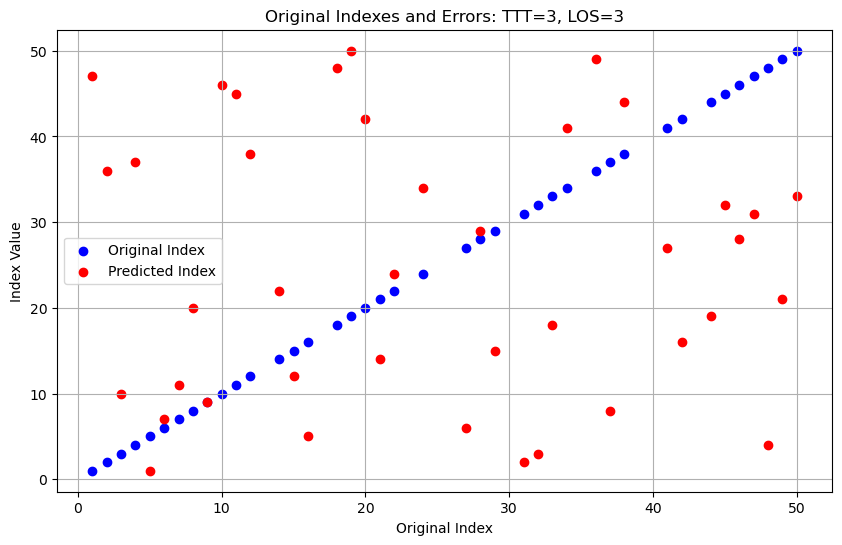

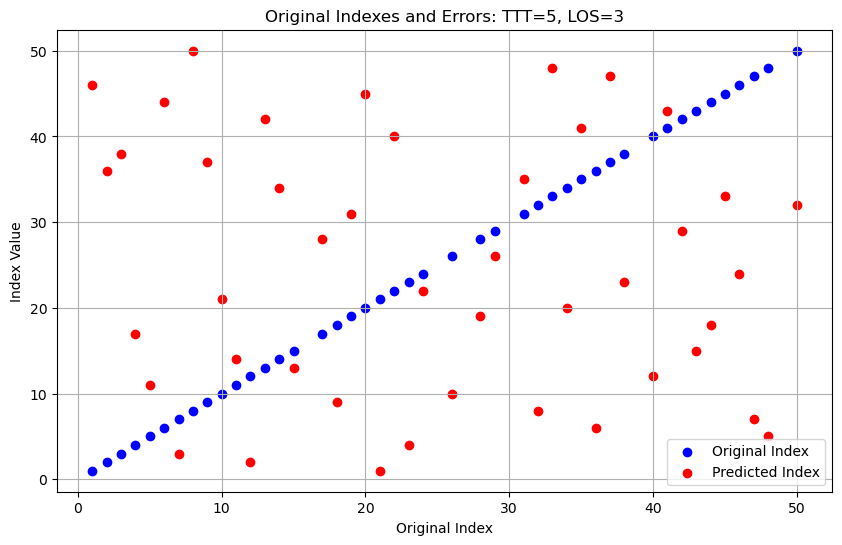

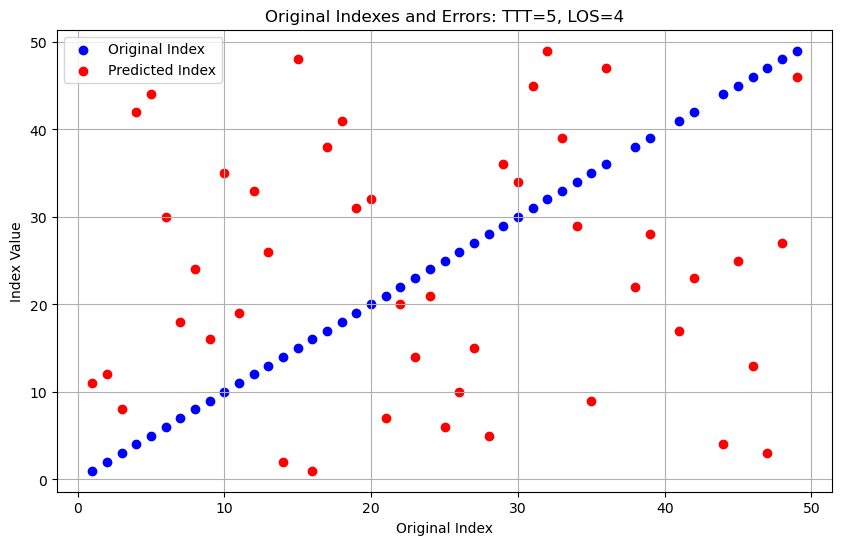

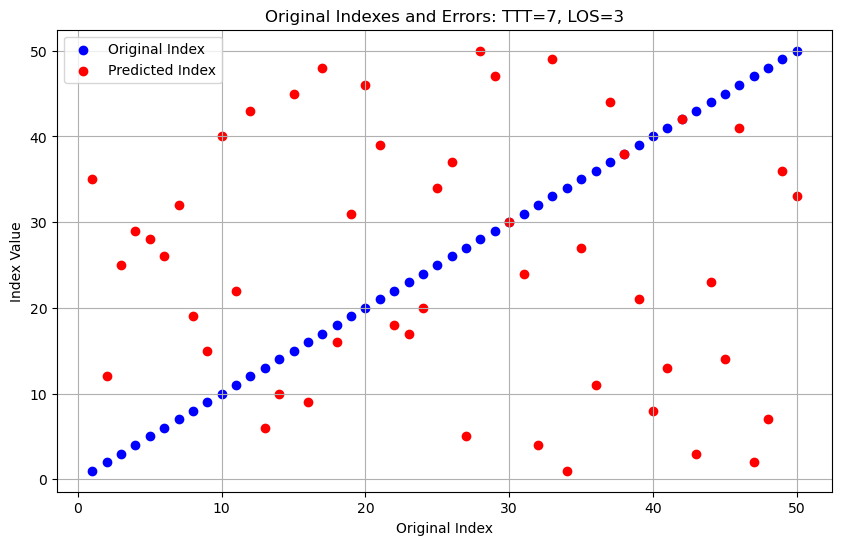

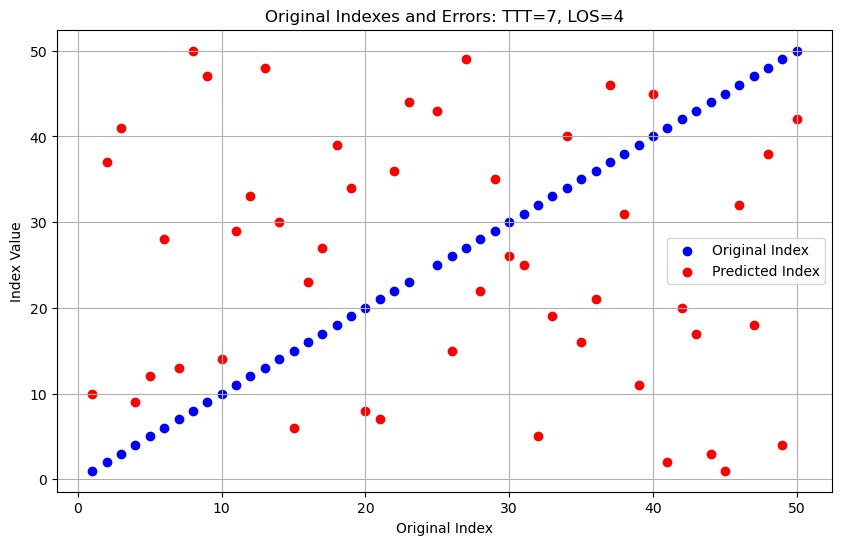

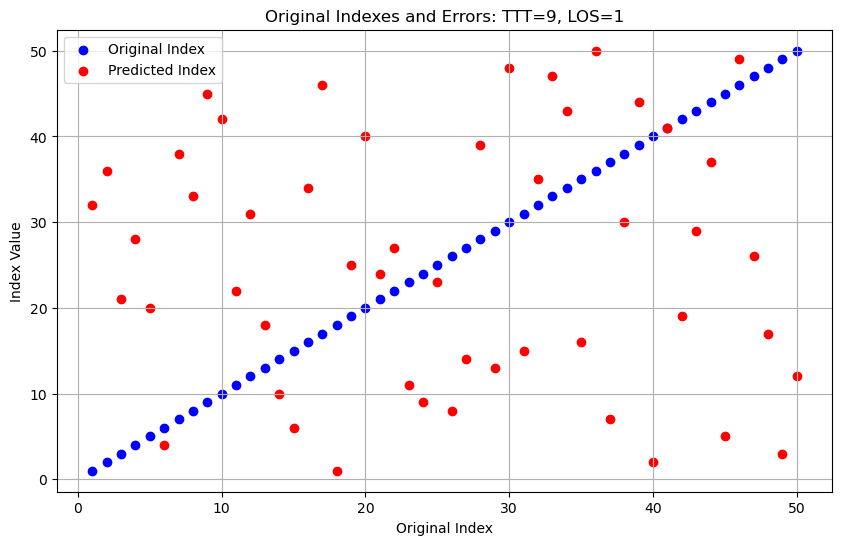

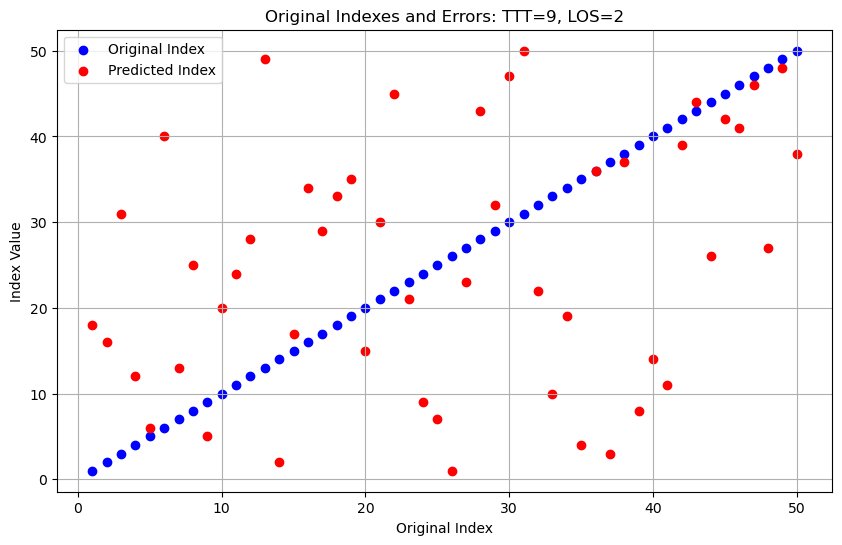

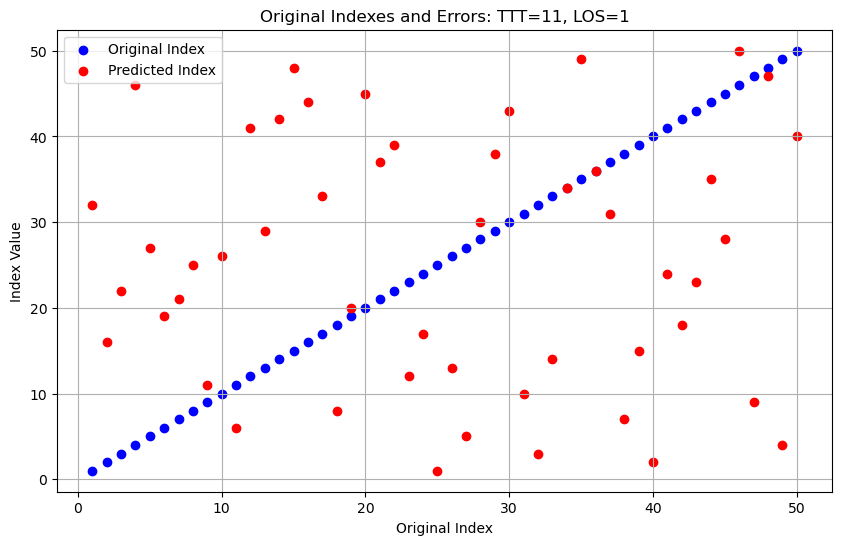

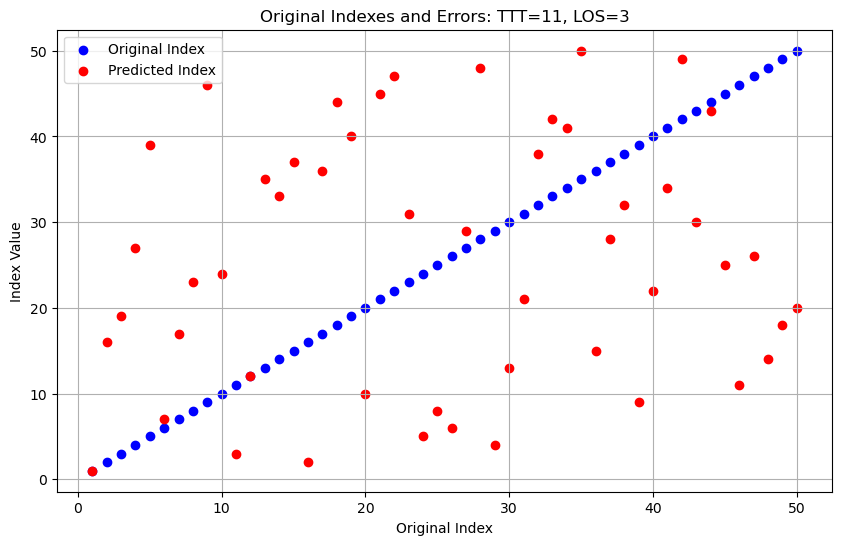

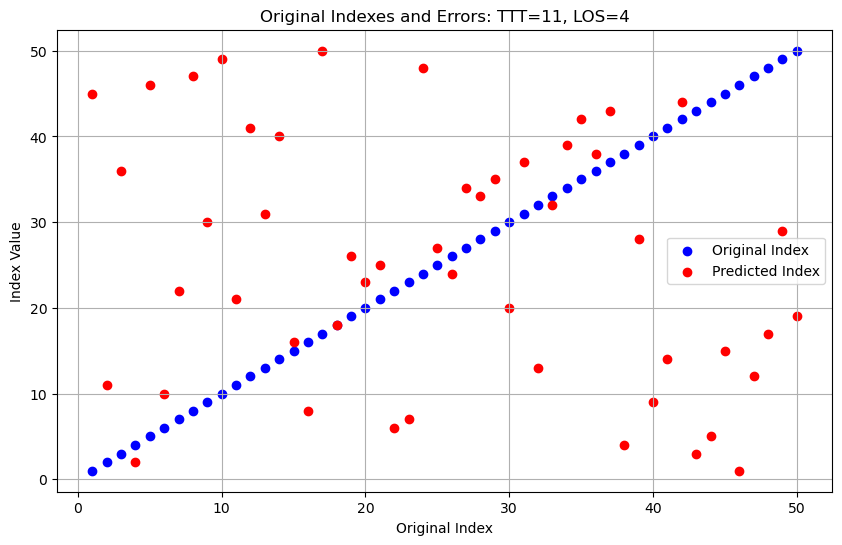

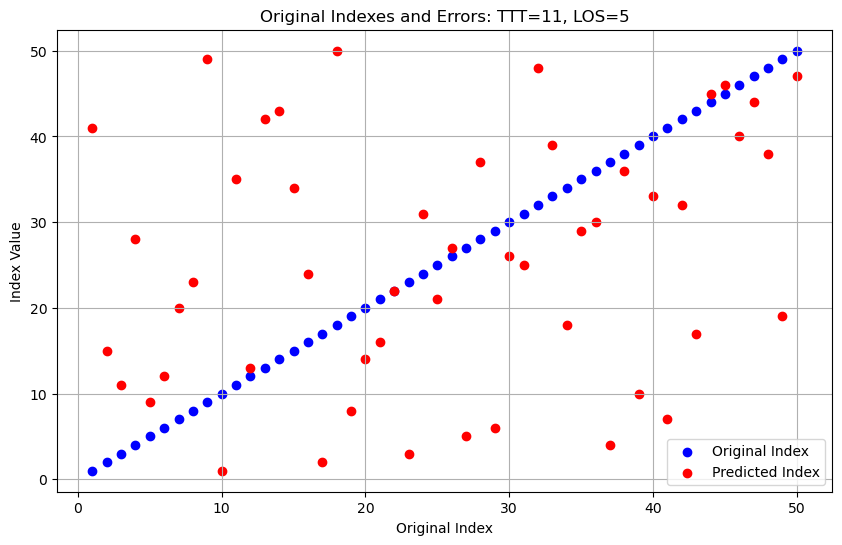

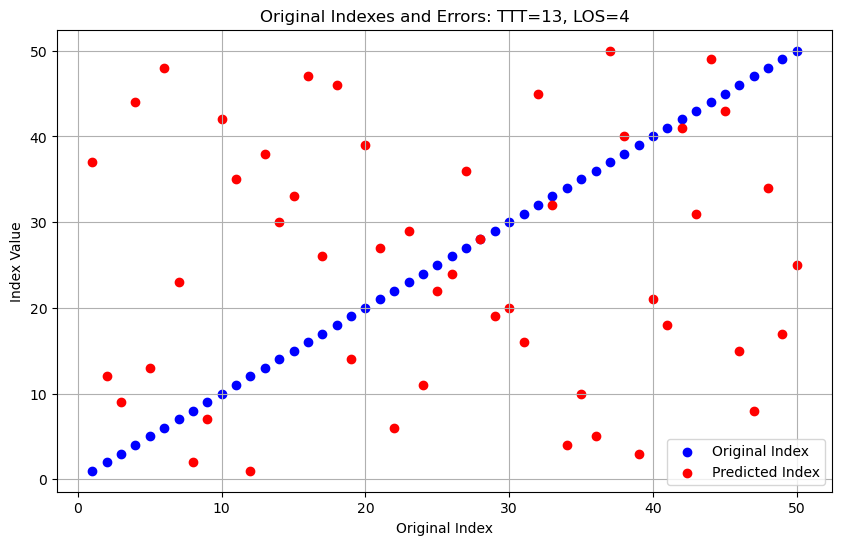

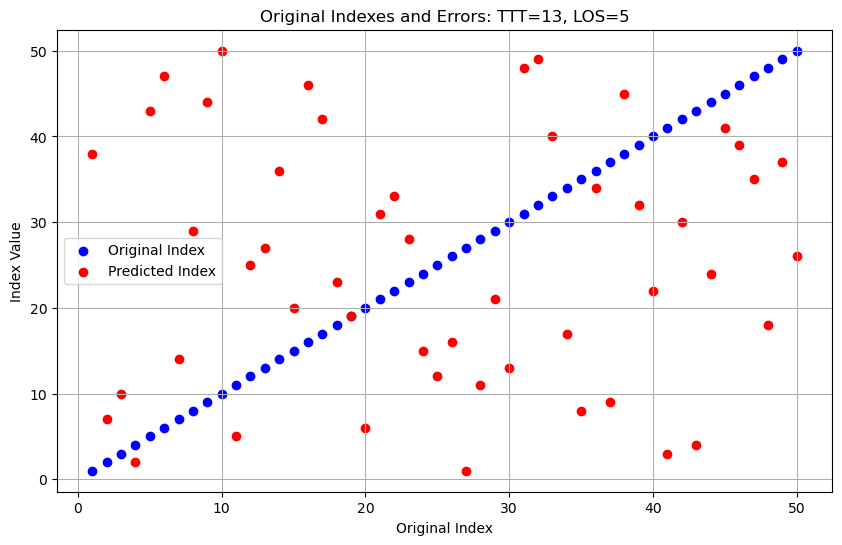

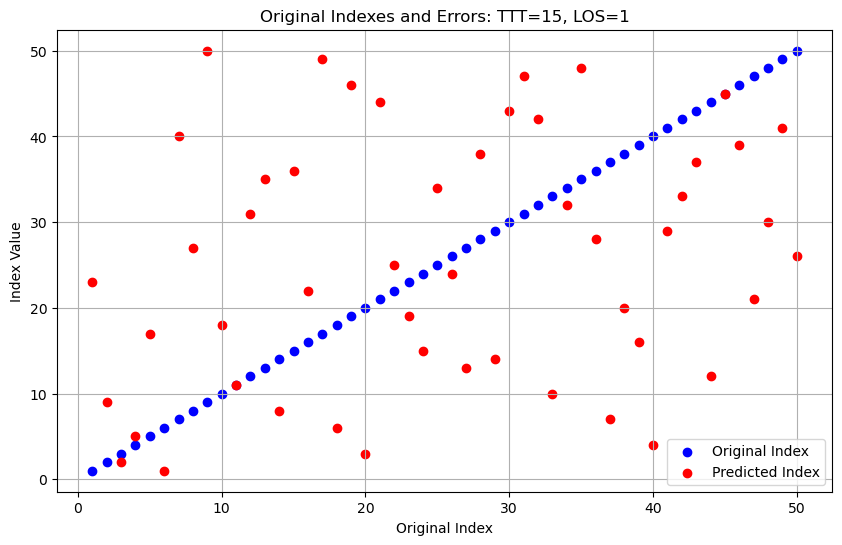

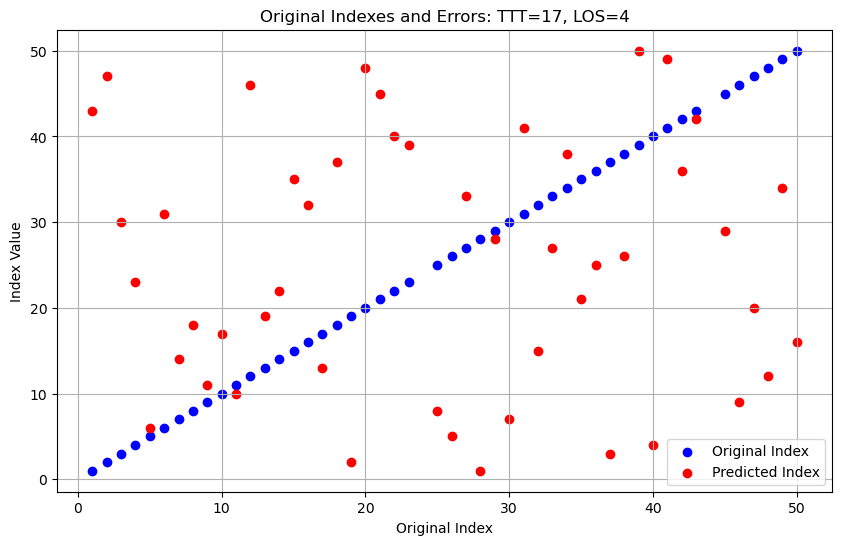

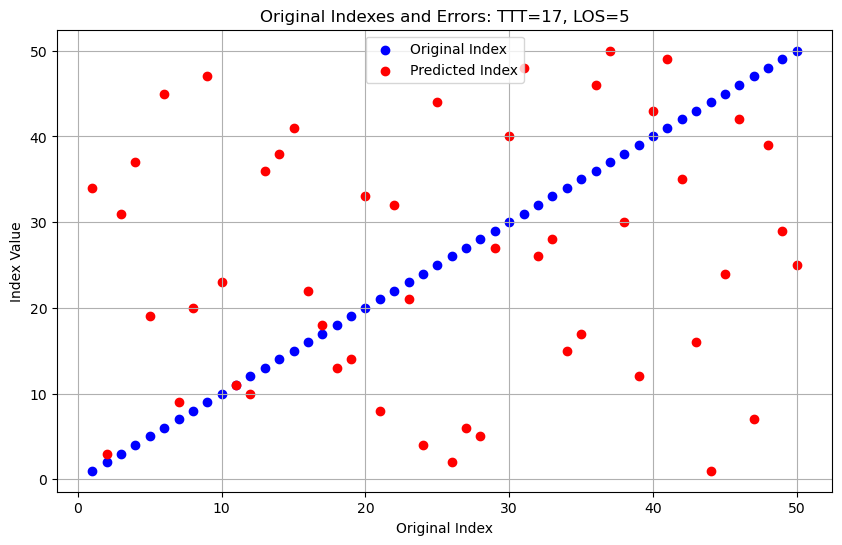

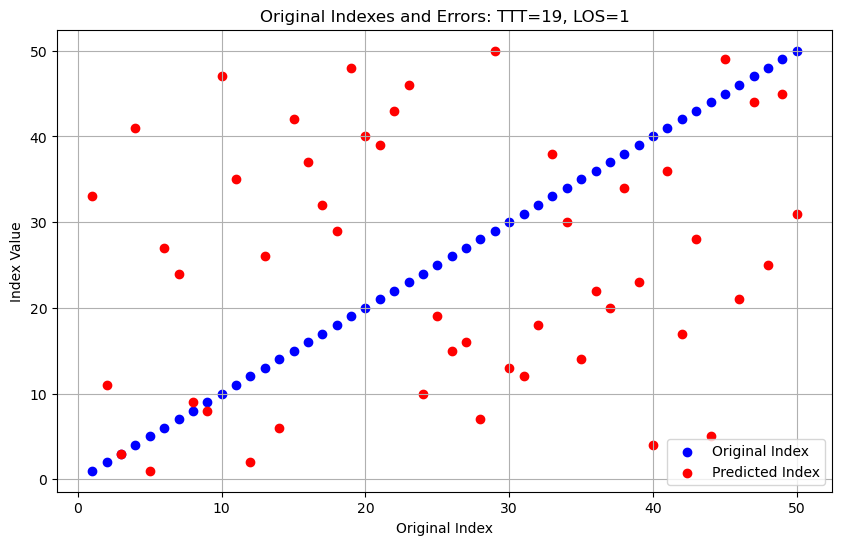

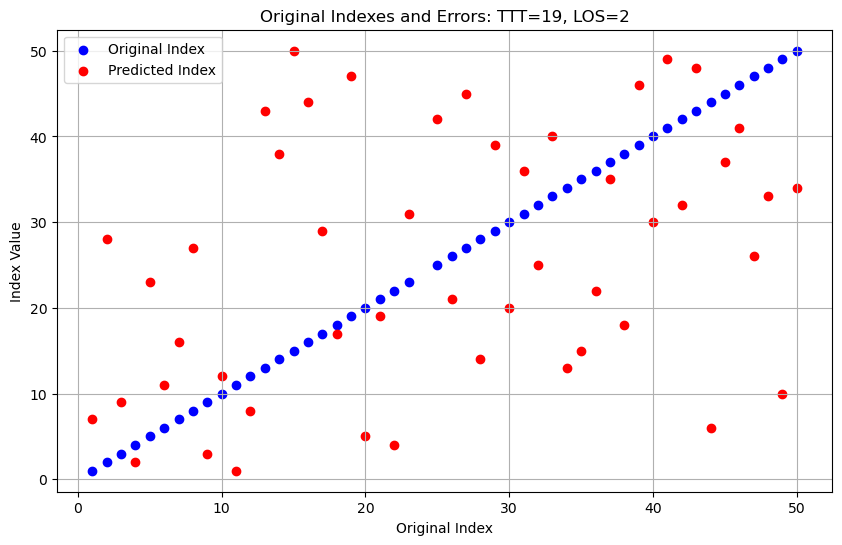

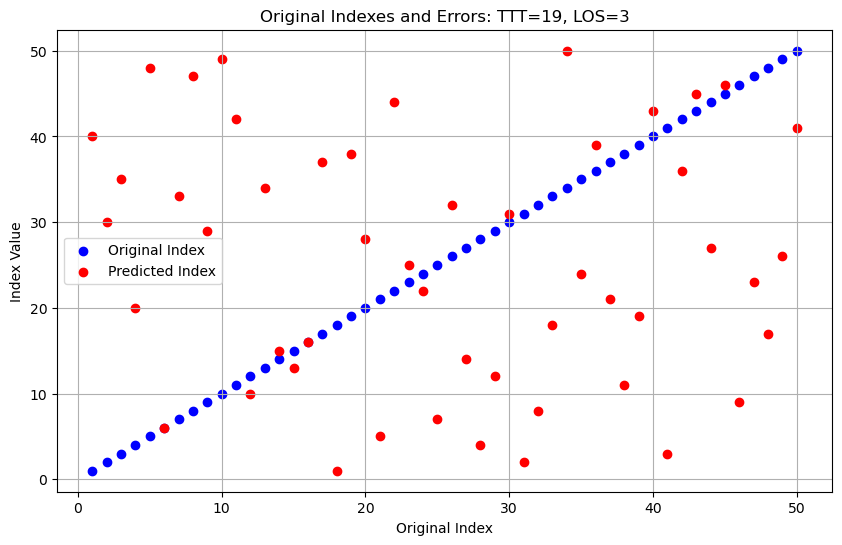

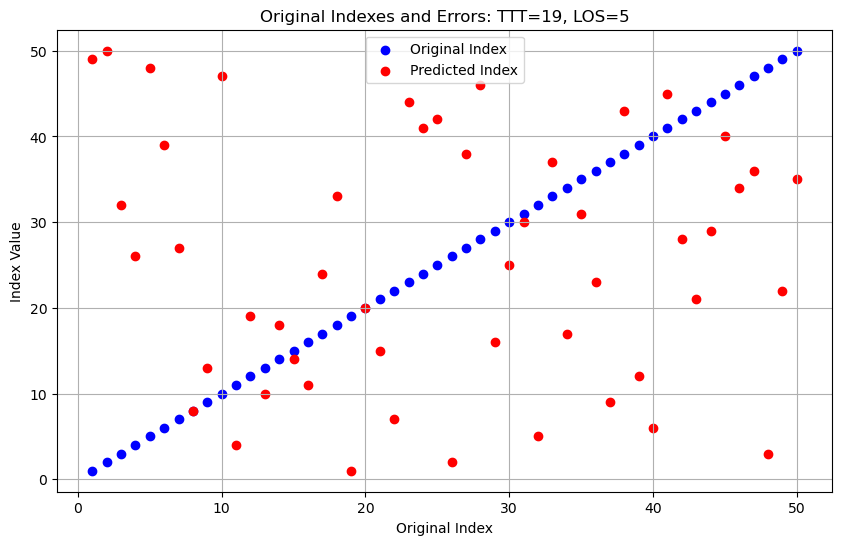

Average Error: 19951.1
Standard Deviation of Errors: 3117.078919437235


In [317]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature columns
feature_columns = ['full_price', 'km_from_center', 'star_rating', 'reviews', 'score', 'discount_perc', 'location_rating']

# Assuming df is your DataFrame
# Split data into training and test sets based on TTT values
even_ttt = df[df['TTT'] % 2 == 0]
odd_ttt = df[df['TTT'] % 2 != 0]

print(f"sum of EVEN TTT unique groups: {even_ttt.groupby(['TTT', 'LOS']).ngroups}")
print(f"sum of ODD TTT unique groups: {odd_ttt.groupby(['TTT', 'LOS']).ngroups}")

# Select n unique groups for training
train_groups = even_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=50)
train_data = pd.merge(even_ttt, train_groups, on=['TTT', 'LOS'])

# Select n unique groups for testing
test_groups = odd_ttt.groupby(['TTT', 'LOS']).size().reset_index().sample(n=20)
test_data = pd.merge(odd_ttt, test_groups, on=['TTT', 'LOS'])

# Prepare training data for the classifier
train_X = train_data[feature_columns]
train_y = (train_data['Index'].diff().shift(-1) < 0).astype(int)

# Standardize the features
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)

# Prepare the classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)

# Function to predict the order of two hotels
def predict_order(hotel1, hotel2):
    pair = pd.DataFrame([hotel1, hotel2])
    pair = scaler.transform(pair[feature_columns])
    prediction = knn.predict(pair)
    return 1 if prediction[0] else -1

# Function to perform Bubble Sort based on the prediction model
def bubble_sort_hotels(hotels):
    sorted_hotels = hotels.copy()
    n = len(sorted_hotels)
    for i in range(n):
        for j in range(0, n-i-1):
            hotel1 = sorted_hotels.iloc[j]
            hotel2 = sorted_hotels.iloc[j+1]
            if predict_order(hotel1, hotel2) == 1:
                sorted_hotels.iloc[j], sorted_hotels.iloc[j+1] = sorted_hotels.iloc[j+1], sorted_hotels.iloc[j]
    return sorted_hotels

# Calculate the sum of squared index differences
errors = []
all_original_indices = []
all_sorted_indices = []
accuracy_rates = []

for name, group in test_data.groupby(['TTT', 'LOS']):
    original_indices = group['Index'].values
    shuffled_group = group.sample(frac=1).reset_index(drop=True)
    sorted_group = bubble_sort_hotels(shuffled_group)
    sorted_indices = sorted_group['Index'].values
    error = np.sum((sorted_indices - original_indices)**2)
    errors.append(error)

    # Calculate accuracy
    correct_predictions = sum((sorted_indices[i] < sorted_indices[i+1]) == (original_indices[i] < original_indices[i+1])
                              for i in range(len(sorted_indices) - 1))
    accuracy_rate = correct_predictions / (len(sorted_indices) - 1)
    accuracy_rates.append(accuracy_rate)

    # Plot the original indexes as blue points and the errors as red points for each original index
    plt.figure(figsize=(10, 6))
    plt.scatter(original_indices, original_indices, color='blue', label='Original Index')
    plt.scatter(original_indices, sorted_indices, color='red', label='Predicted Index')
    plt.title(f'Original Indexes and Errors: TTT={group["TTT"].values[0]}, LOS={group["LOS"].values[0]}')
    plt.xlabel('Original Index')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    all_original_indices.extend(original_indices)
    all_sorted_indices.extend(sorted_indices)

# Calculate the average and standard deviation of errors
avg_error = np.mean(errors)
std_error = np.std(errors)

# Display the results
print(f'Average Error: {avg_error}')
print(f'Standard Deviation of Errors: {std_error}')


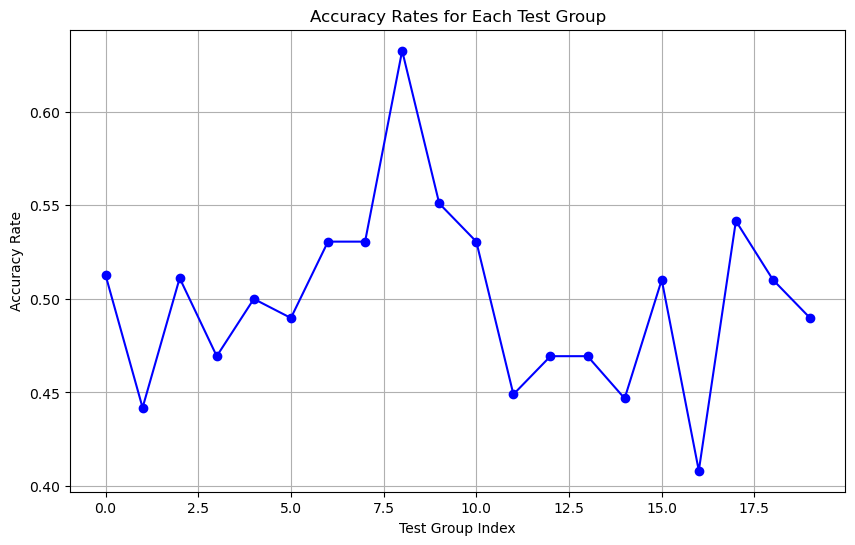

In [318]:
# Plot the overall accuracy rates
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracy_rates)), accuracy_rates, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Rates for Each Test Group')
plt.xlabel('Test Group Index')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()